In [1]:
from functools import partial
import pyautogui
import time
from threading import Timer
import threading
import os
import numpy as np
import pytesseract
from PIL import ImageGrab
import math
pytesseract.pytesseract.tesseract_cmd=r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
from easyocr import Reader
from types import GeneratorType
import re
import cv2
import pygetwindow as gw
import json
from PIL import Image
from operator import itemgetter
from functools import wraps
import keyboard
import logging
import string
import regex
from difflib import SequenceMatcher
import PIL
from helper import read_config
import sys
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(format=' %(asctime)s - %(levelname)s - %(message)s')
import mss
profile = {
    "name": "default profile",
    "agent_type": "nikke",
    "desc": "a default template for Nikke helper",
    "settings":{
        "load_to_memory":True,
        "active_window": "BlueStacks Keymap Overlay"
    },
    "routine": {
        "1":{
            "name":"claim_outpost_reward",
            "display_name": "Claim Outpost Reward",
            "frequency": "daily",
            "priority": 2,
            "auto":True,
            "settings":{
            }
        },
        "2":{
            "name":"claim_friend_points",
            "display_name": "Claim Friend Points",
            "priority": 1,
            "frequency": "daily",
            "auto":True,
            "settings":{
            }
        },
        "3":{
            "name":"advise_nikke",
            "display_name": "Advise Nikke",
            "priority": 3,
            "frequency": "daily",
            "auto":True,
            "settings":{
            }
        },
        "4":{
            "name":"event",
            "display_name": "Repeat Event Levels",
            "priority": 4,
            "frequency": "daily",
            "auto":False,
            "settings":{
                "level_to_repeat":"1-11"
            }
        }, 
        "5":{
            "name":"rookie_arena",
            "display_name": "Rookie Arena",
            "priority": 5,
            "frequency": "daily",
            "auto":True,
            "settings":{
                "max_power_gap": 1000
            }
        }
    }
}

## Nikke Agent

D:\Development\nikke-assistant\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LocationBox:
    def __init__(self, left=0, top=0, width=0, height=0, box=None, _box=None, points=None):
        if box:
            left = box.left
            top = box.top
            width = box.width
            height = box.height
        elif _box:
            left = _box._left
            top = _box._top
            width = _box._width
            height = _box._height
        elif points:
            loc = self.points_to_loc(points)
            left = loc.left
            top = loc.top
            width = loc.width
            height = loc.height

        self.left = left
        self.top = top
        self.width = width
        self.height = height

    def points_to_loc(self, points):
        x_coordinates, y_coordinates = zip(*points)
        return LocationBox(min(x_coordinates),
                           min(y_coordinates),
                           max(x_coordinates)-min(x_coordinates),
                           max(y_coordinates)-min(y_coordinates))

    def to_array(self):
        return [self.left, self.top, self.width, self.height]

    def to_bounding(self):
        return [self.left, self.top, self.left+self.width, self.top+self.height]

    def translate(self, x, y):
        return LocationBox(self.left+x, self.top+y, self.width, self.height)

    def resize(self, width, height):
        return LocationBox(self.left, self.top, width, height)

    def coord(self):
        return np.array([self.left, self.top])

    def size(self):
        return np.array([self.width, self.height])

    def stretch(self, value, axis=0, direction="right", in_place=False):
        new_box = LocationBox(box=self)
        if axis == 0:
            new_box.width += value
            if direction == "left":
                new_box.left -= value
        elif axis == 1:
            new_box.height += value
            if direction == "up":
                new_box.top -= value

        if in_place:
            if axis == 0:
                new_box.width -= self.width
                if direction == "left":
                    new_box.left -= self.width
                elif direction == "right":
                    new_box.left += self.width

            elif axis == 1:
                new_box.height -= self.height
                if direction == "up":
                    new_box.top -= self.height
                elif direction == "down":
                    new_box.top += self.height

        return new_box

    def __sub__(self, other):
        return LocationBox(left=self.left-other.left,
                           top=self.top-other.top,
                           width=self.width-other.width,
                           height=self.height-other.height)

    def __add__(self, other):
        return LocationBox(left=self.left+other.left,
                           top=self.top+other.top,
                           width=self.width+other.width,
                           height=self.height+other.height)

    def __repr__(self):
        return f'LocationBox(left={self.left}, top={self.top}, width={self.width}, height={self.height})'


In [3]:
if getattr(sys, 'frozen', False):
    tes_path = os.path.join(sys._MEIPASS, r'.\\Tesseract-OCR\\tesseract.exe')
    print(f"using {tes_path} as tesseract path")
    pytesseract.pytesseract.tesseract_cmd = tes_path
    # the .exe will look here
else:
    print(f"using default path as tesseract path")
    pytesseract.pytesseract.tesseract_cmd = r"C:\\Program Files\\Tesseract-OCR\\tesseract.exe"
    # use default local path
ImageGrab.grab = partial(ImageGrab.grab, all_screens=True)


class GameInteractionIO:
    bounce_key_delay = 0.07
    inter_key_delay = 0.1
    game_config = read_config('NIKKE_ASSISTANT.INI')
    pre_action_delay = float(game_config.get(
        'app_settings', 'pre_action_delay'))
    post_action_delay = float(game_config.get(
        'app_settings', 'post_action_delay'))
    use_offline_model = (game_config.get(
        'app_settings', 'use_offline_model') == 'True')
    if not pre_action_delay:
        pre_action_delay = 0.5
    if not post_action_delay:
        post_action_delay = 0.5
    language = ['en', 'ch_sim']
    model_path = './EasyOCR/model'
    if not use_offline_model or use_offline_model is False:
        print('using online model')
        reader = Reader(lang_list=language)
    else:
        print('using offline model')
        reader = Reader(
            lang_list=language, model_storage_directory=model_path, download_enabled=False)

    def post_action_generator(pre_delay=0.5, post_delay=0.5):
        def post_action(function):
            @wraps(function)
            def wrapper(*args, **kwargs):
                GameInteractionIO.delay(pre_delay)
                retval = function(*args, **kwargs)
                GameInteractionIO.delay(post_delay)
                return retval
            return wrapper
        return post_action

    def timer(function):
        def wrapper(self, *args, **kwargs):
            func_name = function.__name__
            start_time = time.perf_counter()
            start_local_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            self.logger.info(
                f"The task '{func_name}' started at {start_local_time}")
            retval = function(self, *args, **kwargs)
            end_time = time.perf_counter()
            end_local_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            elapsed_time = end_time - start_time
            self.logger.info(
                f"The task '{func_name}' ended at {end_local_time}")
            hours, remainder = divmod(elapsed_time, 3600)
            minutes, seconds = divmod(remainder, 60)
            self.logger.info(
                f"Timer Summary: The task '{func_name}' took {int(hours)}h {int(minutes)}m {seconds:.2f}s to run.")
            return retval
        return wrapper

    def action_with_change(function):
        def wrapper(self, region=None, *args, **kwargs):
            if not region:
                region = self.location_map['home']
            current_im = GameInteractionIO.get_location_image(region)
            retval = function(self, *args, **kwargs)
            GameInteractionIO.delay(1)
            same_im_loc = GameInteractionIO.exist_image(
                current_im, region=region.to_bounding(), confidence=0.99, timeout=2)
            if same_im_loc:
                return False
            return True
        return wrapper

    post_action = post_action_generator(pre_action_delay, post_action_delay)

    def to_cv2(image):
        return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    def to_pil(image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        im_pil = Image.fromarray(image)
        return im_pil

    def switch_active_application(app_name, app_loc=None):
        app_list = [""]
        if not app_loc:
            app_list = GameInteractionIO.get_available_applications(
                verbose=True)
        else:
            app_list = gw.getWindowsAt(
                *GameInteractionIO.get_image_center(app_loc))
        app = [app for app in app_list if app.title == app_name][0]
        if app:
            try:
                app.activate()
            except:
                app.minimize()
                app.restore()
        else:
            return False
        return True

    def resize_application(app_name="NIKKE", app_loc=None, size=None, position=None):
        app_list = [""]
        if not app_loc:
            app_list = GameInteractionIO.get_available_applications(
                verbose=True)
        else:
            app_list = gw.getWindowsAt(
                *GameInteractionIO.get_image_center(app_loc))

        app = [app for app in app_list if app.title == app_name][0]
        if app and size:
            app.resizeTo(*size)
            if position:
                app.moveTo(*position)
        else:
            return False
        return True

    def get_available_applications(verbose=False):
        app_list = [app for app in pyautogui.getAllWindows()
                    if app.title != ""]
        if not verbose:
            app_list = [app.title for app in app_list]
        return app_list

    def sharpen(image):
        kernel = np.array([[0, -3, 0],
                           [-1, 9, -1],
                           [0, -3, 0]])
        image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
        return image_sharp

    def stretch_white_space(image, empty_count=5):
        white_space = np.array([[255]*(image.shape[1])]*2)
        p = np.concatenate((white_space, image))

        # a = np.array([[255]*(p.shape[0])]).T
        a = p
        empty_count = round(empty_count)
#         prev = 0
#         count = 0
#         digit = []
#         for ind in range(p.shape[1]):
#             if np.mean(p[:, ind]) == 255:
#                 a = np.concatenate((a, p[:, prev:ind+1]), axis=1)
#                 a = np.concatenate((a, np.array([p[:, ind]]*11).T), axis=1)
#                 if np.mean(p[:, prev:ind+1].flatten()) != 255:
#                     digit.append(np.array(p[:, prev:ind+1], dtype=np.uint8))
#                 prev = ind
#                 count += 1
#                 if count > empty_count:
#                     break
#             else:
#                 count = 0

        white_space_count = 0
        max_white_space = empty_count
        prev = 255
        b = np.array([[255]*(a.shape[0])]).T
        filler = np.array([[255]*(a.shape[0])]).T
        for ind in range(a.shape[1]):
            cur = np.mean(a[:, ind])
            # print(cur)
            if cur >= 250:
                if prev >= 250:
                    if white_space_count <= max_white_space:
                        b = np.concatenate((b, filler), axis=1)
                        white_space_count += 1
                else:
                    b = np.concatenate((b, filler), axis=1)
                    white_space_count = 0
            else:
                if prev >= 250 and (white_space_count < max_white_space):
                    b = np.concatenate(
                        (b, np.array([[255]*(a.shape[0])]*(max_white_space-white_space_count)).T), axis=1)
                b = np.concatenate((b, a[:, [ind]]), axis=1)
                white_space_count = 0
            prev = cur

        b = b.astype(np.uint8)
        return b

    def preprocess_image(image, threshold='global'):
        """
        preprocess a PIL image to make it more visible for text recognition
        """
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if threshold == 'global':
            ret, thresh = cv2.threshold(gray, 110, 255, cv2.THRESH_BINARY)
            new_image = thresh
        elif threshold == 'adaptive':
            thresh = cv2.adaptiveThreshold(
                gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, 2)
            erode = cv2.erode(thresh, np.array((7, 7)), iterations=1)
            new_image - erode
        return new_image

    def resize(im, ratio):
        return im.resize((round(s*ratio) for s in im.size))

    def is_white_background(image, threshold=0.3):
        """remove images with transparent or white background"""
        background = np.array([230, 230, 255])
        percent = (image >= background).sum() / image.size
        if percent >= threshold:
            return True
        else:
            return False

    def preprocess_image_text(image, threshold=80):
        """
        preprocess a PIL image to make it more visible for text recognition
        """
        # resize to best size
        # image = GameInteractionIO.resize(image, 2)

        # convert to cv2 format
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        # normalize image
        normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

        # invert image if background is black
        if not GameInteractionIO.is_white_background(normalized, threshold=0.2):
            normalized = cv2.bitwise_not(normalized)

        # grayscale
        gray = cv2.cvtColor(normalized, cv2.COLOR_BGR2GRAY)

        # threshold
        ret, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

        return thresh

    def preprocess_image_number(image, threshold=80):
        """
        preprocess a PIL image to make it more visible for text recognition
        """
        # resize to best size
        image = GameInteractionIO.resize(image, 2)

        # convert to cv2 format
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        # normalize image
        normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

        # invert image if background is black
        if not GameInteractionIO.is_white_background(normalized, threshold=0.2):
            normalized = cv2.bitwise_not(normalized)

        # grayscale
        gray = cv2.cvtColor(normalized, cv2.COLOR_BGR2GRAY)

        # threshold
        ret, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

        # blur and sharppen
        blured = cv2.GaussianBlur(thresh, (3, 3), 0)
        sharpened = GameInteractionIO.sharpen(blured)

        # erode
        # erode = cv2.erode(sharpened, np.array((3, 3)), iterations=1)

        # stretch space
        stretch_image = GameInteractionIO.stretch_white_space(sharpened, 4*2)

        return stretch_image

    def read_text(image_name, model_name=None, detail=1, in_line=True):
        if not model_name:
            model_name = GameInteractionIO.reader

        frame = cv2.cvtColor(np.array(image_name), cv2.COLOR_RGB2BGR)

        # Read the data
        result = model_name.readtext(frame, detail=detail, paragraph=in_line)
        return result

    def read_text_line(image_name):
        result = pytesseract.image_to_string(
            image_name, config=f'-l chi_sim_best --oem 1 --psm 6').strip().replace(" ", "")
        return result

    def remove_punc_unicode(text):
        return regex.sub('[\p{P}\p{Sm}]+', '', text)

    def text_sim_simple(a, b):
        return SequenceMatcher(None, a, b).ratio()

    def _read_number(image, l=0, im_type=6, model_type='digits', threshold=120):
        if l == 0:
            value = pytesseract.image_to_string(image,
                                                config=f'-l eng --oem 1 --psm {im_type} outputbase digits tessedit_char_whitelist=0123456789').strip().replace(" ", "")
        elif l == 1:
            image = GameInteractionIO.preprocess_image_number(image, threshold)
            value = pytesseract.image_to_string(image,
                                                config=f'-l {model_type} --oem 1 --psm {im_type} outputbase digits tessedit_char_whitelist=0123456789').strip().replace(" ", "")

        value = re.sub('[^A-Za-z0-9]+', '\n', value)
        if not value.isdigit():
            return False
        value = int(value)
        return value

    def read_number(image, l=0, threshold=80):
        """
        image types
        #   0    Orientation and script detection (OSD) only.
        #   1    Automatic page segmentation with OSD.
        #   2    Automatic page segmentation, but no OSD, or OCR.
        #   3    Fully automatic page segmentation, but no OSD. (Default)
        #   4    Assume a single column of text of variable sizes.
        #   5    Assume a single uniform block of vertically aligned text.
        #   6    Assume a single uniform block of text.
        #   7    Treat the image as a single text line.
        #   8    Treat the image as a single word.
        #   9    Treat the image as a single word in a circle.
        #  10    Treat the image as a single character.
        #  11    Sparse text. Find as much text as possible in no particular order.
        #  12    Sparse text with OSD.
        #  13    Raw line. Treat the image as a single text line,
        #             bypassing hacks that are Tesseract-specific.
        """
        value = False
        im_type_list = [6, 8, 10, 12]
        model_type_list = ['digitsall_layer',
                           'digits',
                           'engrestrict_best_int'
                           ]
        value_list = []
        for im_type in im_type_list:
            for model_type in model_type_list:
                value = GameInteractionIO._read_number(
                    image, l, im_type, model_type, threshold)
                if value:
                    value_list.append(value)
        if not value:
            value = GameInteractionIO.read_text(image, detail=0)
            if value:
                value = value[0]
                value = re.sub('[^A-Za-z0-9]+', '\n', value)
                if value.isdigit():
                    value = int(value)
                    value_list.append(value)
        if len(value_list) > 0:
            value = max(value_list)
        else:
            value = False
        return value

    def repeat_press(key, hold_time):
        start_time = time.time()
        while time.time() - start_time < hold_time:
            pyautogui.press(key)

    def hold_key(key, hold_time):
        pyautogui.keyDown(key)
        time.sleep(hold_time)
        pyautogui.keyUp(key)

    def hold_key_combo(keydown, key):
        pyautogui.keyDown(keydown)
        pyautogui.keyDown(key)
        time.sleep(GameInteractionIO.inter_key_delay)
        pyautogui.keyUp(key)
        pyautogui.keyUp(keydown)

    def double_click(key):
        pyautogui.keyDown(key)
        time.sleep(GameInteractionIO.bounce_key_delay)
        pyautogui.keyUp(key)
        time.sleep(GameInteractionIO.inter_key_delay)
        pyautogui.keyDown(key)
        time.sleep(GameInteractionIO.bounce_key_delay)
        pyautogui.keyUp(key)

    def single_click(key):
        pyautogui.keyDown(key)
        time.sleep(GameInteractionIO.bounce_key_delay)
        pyautogui.keyUp(key)

    def scroll(distance):
        pyautogui.scroll(distance)
        time.sleep(GameInteractionIO.inter_key_delay)

    def click_and_drag(location, direction=None, dest_coord=None, button='left', duration=2):
        src_coord = GameInteractionIO.move_to_image_location(location)
        if direction:
            pyautogui.drag(*direction, button=button, duration=duration)
        elif dest_coord:
            pyautogui.dragTo(*dest_coord, button=button, duration=duration)

    def mouse_right_click(cursor_coord=[None, None]):
        pyautogui.click(*cursor_coord, clicks=1, interval=1, button='right')

    def mouse_left_click(cursor_coord=[None, None]):
        pyautogui.click(*cursor_coord, clicks=1, interval=1, button='left')

    def mouse_right_double_click(cursor_coord):
        pyautogui.click(*cursor_coord, clicks=2, interval=0.1, button='right')

    def mouse_left_double_click(cursor_coord):
        pyautogui.click(*cursor_coord, clicks=2, interval=0.1, button='left')

    def mouse_multiclick(cursor_coord, clicks=2, interval=0.1, button='left'):
        pyautogui.click(*cursor_coord, clicks=clicks,
                        interval=interval, button='left')

    def delay(delay_time):
        if delay_time < 0:
            delay_time = 0
        time.sleep(delay_time)

    def get_image_center(location):
        return np.array([location.left + location.width//2, location.top + location.height//2])

    def get_window_info(logo_path, resolution):
        window_corner_location = GameInteractionIO.locate_image(
            logo_path, confidence=0.9)
        if not window_corner_location:
            return None
        offset = [-3, -4, 0, 20]
        # offset = [-3, 16, 0, 0]
        x_min = window_corner_location.left + offset[0]
        width = resolution[0] + offset[2]
        y_min = window_corner_location.top + offset[1]
        height = resolution[1] + offset[3]
        window_info_array = [x_min, y_min, width, height]
        window_info_location = LocationBox(*window_info_array)
        return window_info_location

    def _rmse(measured, truth):
        rmse = np.linalg.norm(measured - truth) / np.sqrt(len(truth))
        return rmse

    def _remove_duplicated_location_once(image_location_list, threshold=0.1):
        if not image_location_list:
            return image_location_list
        il_prev = image_location_list[0]
        new_image_location_list = [il_prev]
        for il in image_location_list[1:]:
            if abs(il.top - il_prev.top) > il.height*threshold or abs(il.left - il_prev.left) > il.width*threshold:
                new_image_location_list.append(il)
                il_prev = il
        return new_image_location_list

    def _remove_duplicated_location(image_location_list, threshold=0.1):
        if not image_location_list:
            return image_location_list

        new_image_location_list = GameInteractionIO.non_maximum_suppresion(
            image_location_list, threshold=threshold)

        return new_image_location_list

    def non_maximum_suppresion(loc_list, threshold=0.4):
        boxes = np.array([loc.to_bounding() for loc in loc_list])
        # Return an empty list, if no boxes given
        if len(boxes) == 0:
            return []
        x1 = boxes[:, 0]  # x coordinate of the top-left corner
        y1 = boxes[:, 1]  # y coordinate of the top-left corner
        x2 = boxes[:, 2]  # x coordinate of the bottom-right corner
        y2 = boxes[:, 3]  # y coordinate of the bottom-right corner
        # Compute the area of the bounding boxes and sort the bounding
        # Boxes by the bottom-right y-coordinate of the bounding box
        # We add 1, because the pixel at the start as well as at the end counts
        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        # The indices of all boxes at start. We will redundant indices one by one.
        indices = np.arange(len(x1))
        for i, box in enumerate(boxes):
            # Create temporary indices
            temp_indices = indices[indices != i]
            # Find out the coordinates of the intersection box
            xx1 = np.maximum(box[0], boxes[temp_indices, 0])
            yy1 = np.maximum(box[1], boxes[temp_indices, 1])
            xx2 = np.minimum(box[2], boxes[temp_indices, 2])
            yy2 = np.minimum(box[3], boxes[temp_indices, 3])
            # Find out the width and the height of the intersection box
            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)
            # compute the ratio of overlap
            overlap = (w * h) / areas[temp_indices]
            # if the actual boungding box has an overlap bigger than treshold with any other box, remove it's index
            if np.any(overlap) > threshold:
                indices = indices[indices != i]
        # return only the boxes at the remaining indices
        return [loc_list[ind] for ind in indices]

    def locate_image(image_path, master_image_path=None, confidence=0.8, region=None, multi=False, multi_threshold=0.3):
        if isinstance(image_path, list):
            location_list = []
            for im in image_path:
                if master_image_path:
                    if multi:
                        image_location = pyautogui.locateAll(
                            im, master_image_path, confidence=confidence)
                    else:
                        image_location = pyautogui.locate(
                            im, master_image_path, confidence=confidence)
                else:
                    if multi:
                        image_location = pyautogui.locateAllOnScreen(
                            im, confidence=confidence, region=region)
                    else:
                        image_location = pyautogui.locateOnScreen(
                            im, confidence=confidence, region=region)
                if image_location is not None:
                    if isinstance(image_location, GeneratorType):
                        image_location = [LocationBox(
                            *il) for il in image_location]
                        image_location = GameInteractionIO._remove_duplicated_location(
                            image_location, threshold=multi_threshold)
                    elif image_location is not None:
                        image_location = LocationBox(*image_location)
                    location_list.append(image_location)
            return location_list
        else:
            if master_image_path:
                if multi:
                    image_location = pyautogui.locateAll(
                        image_path, master_image_path, confidence=confidence)
                else:
                    image_location = pyautogui.locate(
                        image_path, master_image_path, confidence=confidence)
            else:
                if multi:
                    image_location = pyautogui.locateAllOnScreen(
                        image_path, confidence=confidence, region=region)
                else:
                    image_location = pyautogui.locateOnScreen(
                        image_path, confidence=confidence, region=region)
            if isinstance(image_location, GeneratorType):
                image_location = [LocationBox(*il) for il in image_location]
                image_location = GameInteractionIO._remove_duplicated_location(
                    image_location, threshold=multi_threshold)
            elif image_location is not None:
                image_location = LocationBox(*image_location)
            return image_location if image_location else None

    def exist_image(image_path, master_image_path=None, confidence=0.8, region=None, loop=False, timeout=10):
        image_location = None
        if isinstance(image_path, list):
            location_list = []
            if loop is True:
                wait_time = 0
                while image_location is None and wait_time < timeout:
                    for im in image_path:
                        if master_image_path:
                            image_location = pyautogui.locate(
                                im, master_image_path, confidence=confidence)
                        else:
                            image_location = pyautogui.locateOnScreen(
                                im, confidence=confidence, region=region)
                        if image_location is None:
                            GameInteractionIO.delay(1)
                            wait_time += 1
                            break
                if image_location is None:
                    return False
            else:
                for im in image_path:
                    if master_image_path:
                        image_location = pyautogui.locate(
                            im, master_image_path, confidence=confidence)
                    else:
                        image_location = pyautogui.locateOnScreen(
                            im, confidence=confidence, region=region)
                    if image_location is None:
                        return False
        else:
            if loop is True:
                wait_time = 0
                while image_location is None and wait_time < timeout:
                    if master_image_path:
                        image_location = pyautogui.locate(
                            image_path, master_image_path, confidence=confidence)
                    else:
                        image_location = pyautogui.locateOnScreen(
                            image_path, confidence=confidence, region=region)
                    if image_location is None:
                        GameInteractionIO.delay(1)
                        wait_time += 1
                        break
                if image_location is None:
                    return False
            else:
                if master_image_path:
                    image_location = pyautogui.locate(
                        image_path, master_image_path, confidence=confidence)
                else:
                    image_location = pyautogui.locateOnScreen(
                        image_path, confidence=confidence, region=region)
                if image_location is None:
                    return False
        return True

    def move_to_image_location(location, alignment='center'):
        image_cord = [location.left, location.top]
        if alignment == 'center':
            image_cord[0] += location.width//2
            image_cord[1] += location.height//2
        pyautogui.moveTo(*image_cord)
        return image_cord

    def get_direction(source_location, destination_location):
        source_center = GameInteractionIO.get_image_center(source_location)
        destination_center = GameInteractionIO.get_image_center(
            destination_location)
        direction = destination_center - source_center
        return direction

    def get_coord(location):
        return np.array([location.left, location.top])

    def mouse_center(window_center):
        pyautogui.moveTo(*window_center)

    def mouse_center_click(image_location):
        window_center = GameInteractionIO.get_image_center(image_location)
        pyautogui.click(*window_center, clicks=1, interval=1, button='left')

    def locate_image_and_double_click(image_path, region_im=None, region_location=None, region=None, button='left'):
        """
        locate an image and double click it
        default using left click
        """
        image_location = GameInteractionIO.locate_image(
            image_path, region_im, confidence=0.8, region=region)
        if not image_location:
            return False
        image_coord = GameInteractionIO.get_image_center(image_location)
        if region_location is not None:
            image_coord += region_location.coord()
        pyautogui.click(*image_coord, clicks=2, interval=1, button=button)
        return True

    @post_action
    def locate_image_and_click(image_path, region_im=None, region_location=None, confidence=0.8,
                               region=None, button='left', loop=False, timeout=10, delay=1):
        """
        locate an image and double click it
        default using left click
        """
        image_location = GameInteractionIO.locate_image(
            image_path, region_im, confidence=confidence, region=region)
        if loop is True:
            wait_time = 0
            while not image_location and wait_time < timeout:
                GameInteractionIO.delay(delay)
                image_location = GameInteractionIO.locate_image(
                    image_path, region_im, confidence=confidence, region=region)
                wait_time += 1
        if not image_location:
            return False
        if isinstance(image_location, list):
            image_location = image_location[0]
        image_coord = GameInteractionIO.get_image_center(image_location)
        if region_location is not None:
            image_coord += region_location.coord()
        if button:
            pyautogui.click(*image_coord, clicks=1, interval=1, button=button)
        return True

    def get_region_location_first_time(region_image_path, window_info):
        """
        based on the given image path, get the relative location of the image in
        the screen w.r.t. the window's center coord 
        """
        region_abs_location = GameInteractionIO.locate_image(
            region_image_path, confidence=0.9, region=window_info)
        region_offset = GameInteractionIO.get_coord(
            region_abs_location) - GameInteractionIO.get_image_center(window_info)
        region_offset_location = LocationBox(
            *region_offset,
            *region_abs_location.size())
        return region_offset_location

    def get_region_location(region_location_offset, window_center_coord):
        """
        based on the region's offset location and the window's center coord
        get the region's current active location
        """
        left = region_location_offset.left + window_center_coord[0]
        top = region_location_offset.top + window_center_coord[1]
        return LocationBox(left, top, *region_location_offset.size())

    def get_sub_region_location(sub_region_offset, region_offset, window_center_coord):
        """
        based on subregion's offset to windows center coord reference and the region's offset to window center coord
        get the subregion's offset location relative to the region's location
        """
        sub_region_location_coord = window_center_coord - \
            region_offset.coord() + sub_region_offset.coord()
        sub_region_location = LocationBox(
            *sub_region_location_coord,
            *sub_region_offset.size()
        )
        return sub_region_location

    def get_location_image(image_location, region_image=None):
        """
            take a screenshot of the image location screen
            if a region_image is provided, use tha region image as the screen instead
        """
        if region_image is not None:
            location_im = region_image.crop(image_location.to_bounding())
        else:
            location_im = ImageGrab.grab(bbox=image_location.to_bounding())
        return location_im

    def capture_screenshot(region=None):
        with mss.mss() as sct:
            monitor = sct.monitors[0]
            if region:
                monitor["left"] += region[0]
                monitor["top"] += region[1]
                monitor["width"] = region[2] - region[0]
                monitor["height"] = region[3] - region[1]
            screenshot = sct.grab(monitor)
            img_array = np.array(screenshot)
            return cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

    def locate_image_mss(image_path, master_image_path=None, confidence=0.8, region=None, multi=False, multi_threshold=0.3):
        with mss.mss() as sct:
            if not isinstance(image_path, list):
                image_path = [image_path]

            image_locations = []
            capture = GameInteractionIO.capture_screenshot(region)
            for im in image_path:
                template = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR) if isinstance(
                    im, Image.Image) else cv2.imread(im, cv2.IMREAD_GRAYSCALE)
                # Grab screenshot and convert to RGB
                img = np.array(capture)[:, :, ::-1]
                res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
                loc = np.where(res >= confidence)
                for pt in zip(*loc[::-1]):
                    box = LocationBox(
                        left=pt[0], top=pt[1], width=template.shape[1], height=template.shape[0])
                    if region:
                        box.left += region[0]
                        box.top += region[1]
                    image_locations.append(box)

            if multi:
                image_locations = GameInteractionIO._remove_duplicated_location(
                    image_locations, threshold=multi_threshold)

            if len(image_locations) == 0:
                return None

            if len(image_locations) == 1:
                return image_locations[0]

            return image_locations


 2023-11-26 16:37:13,380 - WARNING - CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


using default path as tesseract path
using offline model


In [4]:
gio = GameInteractionIO

In [5]:
class Agent:
    def retry_action(timeout=3, delay=3):
        def post_action(function):
            @wraps(function)
            def wrapper(*args, **kwargs):
                attempt = 0
                while attempt < timeout:
                    try:
                        retval = function(*args, **kwargs)
                        return retval
                    except Exception as e:
                        print(e)
                        gio.delay(delay)
                return None
            return wrapper
        return post_action

    def __init__(
        self,
        app_name=None,
        profile=None,
        profile_path=None,
        game_settings=None,
        game_settings_path=None,
        custom_logger=None
    ):
        # set logging
        self.set_logger(custom_logger)

        # load up the profile
        self.load_profile(profile=profile, profile_path=profile_path)

        # Load up game settings
        self.load_game_settings(profile=game_settings,
                                profile_path=game_settings_path)

        # set the active window region
        self.initialize_game(app_name)

    def is_game_active(self):
        return self.game_active if self.game_active else False

    def _sort_dict_by_value(self, unsorted_dict, value):
        """
        helper function to sort a dictionary by the values of it's sub dictionaries
        """
        return {k: v for k, v in sorted(unsorted_dict.items(), key=lambda item: item[1][value])}

    def set_logger(self, custom_logger=None):
        if not custom_logger:
            logging.basicConfig(
                format=' %(asctime)s - %(levelname)s - %(message)s')
            self.logger = logging.getLogger(
                '==============NIKKE DEBUGGER=============')
            self.logger.setLevel(logging.DEBUG)
        else:
            self.logger = custom_logger

    def initialize_game(self, app_name=None):
        # initialize all features
        self.default_resolution = [575, 1022]
        self.default_real_resolution = [591, 1061]
        self.default_advise_nikke_stretch_length = 250
        self.image_path = 'images'
        self.table_path = 'tables'
        self.locale = 'zh'
        self.NIKKE_PC_WINDOW = 'NIKKE'
        self.NIKKE_PC_SCROLL_CONSTANT = 1
        self.init_location_map()
        self.game_active = False
        if not self.set_active_window(app_name):
            return False
        self.set_game_settings()
        if self.settings.get('auto_rescale', {}).get('value'):
            self.resize_to_optimal()
            self.set_active_window(app_name)
        self.setup_image_profile()
        self.setup_table_profile()
        return True

    def select_active_window(self, app_name=None):
        if not app_name:
            app_name = self.settings.get('active_window', {}).get('value')
        if not self.set_active_window(app_name):
            return False
        self.setup_image_profile()
        self.set_game_settings()
        return True

    def resize_image(self, im):
        new_resolution = self.resolution
        if new_resolution != self.default_resolution:
            ratio = new_resolution[1]/self.default_resolution[1]
            im = im.resize((round(s*ratio) for s in im.size))
        return im

    def resize_value(self, value):
        new_resolution = self.resolution
        if new_resolution != self.default_resolution:
            ratio = new_resolution[1]/self.resolution[1]
            value = value*ratio
        return value

    def load_image_path(self, image_path):
        image_path_dict = {}

        for root, dirs, files in os.walk(image_path):
            if root[-1] != "\\":
                root = root+"\\"
            sub_dir = root.replace(image_path+'\\', '')
            for file in files:
                if file.endswith('.png') or file.endswith('.PNG'):
                    pretty_name = "_".join(os.path.join(
                        sub_dir, file).split('.')[0].split('\\'))
                    if self.settings.get('load_to_memory', {}).get('value') is True:
                        image_path_dict[pretty_name] = self.resize_image(
                            Image.open(os.path.join(root, file)))
                    else:
                        image_path_dict[pretty_name] = os.path.join(root, file)
        return image_path_dict

    def setup_image_profile(self):
        """
        load the matching images
        """
        current_path = os.getcwd()
        image_dir_name = self.image_path
        agent_dir_name = self.type

        image_path = os.path.join(current_path, image_dir_name, agent_dir_name)
        self.image_map = self.load_image_path(image_path=image_path)
        return True

    def load_table_path(self, table_path):
        table_path_dict = {}

        for root, dirs, files in os.walk(table_path):
            if root[-1] != "\\":
                root = root+"\\"
            sub_dir = root.replace(table_path+'\\', '')
            for file in files:
                if file.endswith('.json'):
                    pretty_name = "_".join(os.path.join(
                        sub_dir, file).split('.')[0].split('\\'))
                    if self.settings.get('load_to_memory', {}).get('value') is True:
                        with open(os.path.join(root, file), encoding='utf-8') as f:
                            table_path_dict[pretty_name] = json.load(f)
                    else:
                        table_path_dict[pretty_name] = os.path.join(root, file)
        return table_path_dict

    def setup_table_profile(self):
        """
        load the tables
        """
        current_path = os.getcwd()
        table_dir_name = self.table_path
        agent_dir_name = self.type
        locale = self.locale

        table_path = os.path.join(
            current_path, table_dir_name, locale, agent_dir_name)
        self.table_map = self.load_table_path(table_path=table_path)
        return True

    def init_location_map(self):
        self.location_map = {}
        return True

    def set_active_window(self, app_name=None):
        """
        set the current active window info
        """
        if not app_name:
            if self.settings.get('active_window', {}).get('value'):
                app_name = self.settings.get('active_window', {}).get('value')
            else:
                app_name = "NIKKE"

        # get all apps open
        app_list = gio.get_available_applications(verbose=True)

        # find the selected app by name
        app = [app for app in app_list if app.title == app_name]

        if len(app) == 0:
            self.resolution = self.default_resolution
            self.logger.error('cannot find active game window')
            return False
        app = app[0]
        self.settings['active_window']['value'] = app_name

        # record the app location
        app_location = LocationBox(_box=app._rect)

        if app_name == self.NIKKE_PC_WINDOW:
            self.logger.info('Detected PC version of Nikke')
            title_height = 39
            edge_width = 8

            app_location = app_location.stretch(-title_height, axis=1, direction='down'
                                                ).translate(0, title_height-edge_width
                                                            ).stretch(-edge_width*2, axis=0, direction='left'
                                                                      ).translate(-edge_width, 0)

        self.location_map['home'] = app_location
        # the location of the event window
        # TODO: make the resolution scalable
        self.location_map['event'] = app_location.stretch(
            -285, axis=1).translate(0, 200)

        self.location_map['shop'] = app_location + \
            LocationBox(left=86, top=475, width=-94, height=-563)

        self.location_map['next'] = app_location + \
            LocationBox(left=527, top=508, width=-537, height=-973)

        self.location_map['prev'] = app_location + \
            LocationBox(left=8, top=506, width=-539, height=-969)

        self.resolution = [app_location.width, app_location.height]
        self.res_multi = self.resolution[1]/self.default_resolution[1]
        self.game_active = True
        self.logger.info('succesfully detected app window')
        return True

    def load_profile(self, profile=None, profile_path=None):
        """
        load the skill profile for a given agent based on either a skill_path or a skill profile
        if none provided, the profile will be initialized to the default profile from the default skill 
        """
        if not profile_path:
            default_profile_path = 'agent\\default\\default_nikke_profile.json'
            current_path = os.getcwd()
            profile_path = os.path.join(current_path, default_profile_path)

        if not profile:
            with open(profile_path, encoding='utf-8') as f:
                profile = json.load(f)

        self.profile_path = profile_path
        self.profile_name = profile.get('name', 'unknown name')
        self.desc = profile.get('desc', 'unknown desc')
        self.routine = profile.get('routine', 'unknown routine')
        self.type = profile.get('agent_type', 'unknown type')
        self.settings = profile.get('settings', 'unknown settings')

        self.logger.info('Loaded profile {}'.format(self.profile_name))

    def load_game_settings(self, profile=None, profile_path=None):
        """
        load the skill profile for a given agent based on either a skill_path or a skill profile
        if none provided, the profile will be initialized to the default profile from the default skill 
        """
        if not profile_path:
            default_profile_path = 'agent\\default\\game_settings.json'
            current_path = os.getcwd()
            profile_path = os.path.join(current_path, default_profile_path)

        if not profile:
            with open(profile_path) as f:
                profile = json.load(f)

        setting_type = 'default'
        self.game_settings = profile.get(setting_type)
        self.logger.info(f'loaded {setting_type} game settings')

    def set_game_settings(self, setting_type='default'):
        # if resolution changed, modify all game related variables that would change with resolution
        settings = self.game_settings
        if self.res_multi != 1:
            m = self.res_multi
            for module, content in self.game_settings.items():
                for s_type, setting in content.items():
                    if s_type == 'var':
                        for k, v in setting.items():
                            setting[k] = round(v*m)
        self.game_settings = settings
        return True

    def save_profile(self):
        profile = {}
        profile['name'] = self.profile_name
        profile['desc'] = self.desc
        profile['routine'] = self.routine
        profile['agent_type'] = self.type
        profile['settings'] = self.settings

        with open(self.profile_path, 'w', encoding='utf-8') as json_file:
            json.dump(profile, json_file, ensure_ascii=False, indent=4)
        self.logger.info(f'Succesfully saved profile to {self.profile_path}')

    def focus(self):
        return gio.switch_active_application(app_name=self.settings.get('active_window', {}).get('value'), app_loc=self.location_map['home'])

    def resize(self, resolution=None, position=None):
        if not resolution:
            resolution = self.default_real_resolution
        gio.resize_application(app_name=self.settings.get('active_window', {}).get('value'),
                               app_loc=self.location_map['home'],
                               size=resolution,
                               position=position)
        self.select_active_window()
        return True

    def resize_to_optimal(self):
        position = None
        # position = [0,0]
        self.resize(resolution=self.default_real_resolution, position=position)

    def is_home(self):
        pass

    def terminate_action(self):
        raise KeyboardInterrupt

    def back(self):
        gio.single_click('esc')
        gio.delay(1)

    def exit_to_home(self):
        self.logger.info('Exiting to home...')
        potential_actions = [self.image_map['home_outpost_express_reward'],
                             self.image_map['home_outpost_express_confirm'],
                             self.image_map['home_outpost_express_level_up']]

        # click on first available action to exit the outpost express claim panel
        gio.locate_image_and_click(potential_actions,
                                   region=self.location_map['home'].to_bounding(), loop=True, timeout=2)

        if gio.locate_image_and_click(self.image_map['home_flash_sale'],
                                      region=self.location_map['home'].to_bounding(), loop=True, timeout=2):
            gio.locate_image_and_click(self.image_map['confirm'],
                                       region=self.location_map['home'].to_bounding(), loop=True, timeout=2)

        gio.locate_image_and_click(self.image_map['back_home'],
                                   region=self.location_map['home'].to_bounding(), loop=True, timeout=3)

        item_list = [self.image_map['home_blabla'],
                     self.image_map['home_friend']]
        self.focus()
        while gio.exist_image(item_list, region=self.location_map['home'].to_bounding()) is False:
            self.back()
        self.logger.info('Exited to home succesfully')
        return True

    @gio.action_with_change
    def scroll(self, scroll_distance=100, direction='down', delay=2, time=11):
        if self.settings['active_window'].get('value') == self.NIKKE_PC_WINDOW:
            time = time*self.NIKKE_PC_SCROLL_CONSTANT

        direction_multiplier = 1 if direction == 'up' else -1
        gio.move_to_image_location(self.location_map['home'])
        for _ in range(time):
            gio.scroll(direction_multiplier*scroll_distance)
        gio.delay(delay)

    @gio.action_with_change
    def drag(self, loc, direction=None, dest_coord=None, delay=1, duration=1):
        if not loc:
            return False
        if not direction and not dest_coord:
            direction = [-200, 0]

        if direction:
            gio.click_and_drag(loc, direction=direction, duration=duration)
        elif dest_coord:
            gio.click_and_drag(loc, dest_coord=dest_coord, duration=duration)
        gio.delay(delay)
        return True

    def claim_outpost_reward_wipe(self):
        """
            try to do outpost wipe
        """
        self.logger.info('Checking if outpost wipe is available')
        wipe_count = 0
        # return to home if not on the page and enter the screen
        if not gio.locate_image(self.image_map['home_outpost_express_wipe'],
                                region=self.location_map['home'].to_bounding()):
            self.exit_to_home()
            gio.locate_image_and_click(self.image_map['home_outpost_express'],
                                       region=self.location_map['home'].to_bounding(), confidence=0.8)

        gio.locate_image_and_click(self.image_map['home_outpost_express_wipe'],
                                   region=self.location_map['home'].to_bounding(), loop=True, timeout=2)
        # if the wipe is free
        if not gio.locate_image(self.image_map['home_outpost_express_wipe_gem'],
                                region=self.location_map['home'].to_bounding()):
            if gio.locate_image_and_click(self.image_map['home_outpost_express_wipe_wipe'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=2):
                wipe_count += 1

        self.logger.info(f'Performed {wipe_count} outpost wipe')
        self.exit_to_home()

    def claim_outpost_reward(self):
        """
            claim the rewards for the outposts
        """
        self.logger.info("claiming outpost reward start")

        # click on outpost
        if not gio.locate_image_and_click(self.image_map['home_outpost_express'],
                                          region=self.location_map['home'].to_bounding(), confidence=0.8):
            if not gio.locate_image_and_click(self.image_map['home_outpost_express_full'],
                                              region=self.location_map['home'].to_bounding(), confidence=0.8):
                self.logger.warning('could not locate outpost express')
                return False

        # click on get reward
        gio.locate_image_and_click(self.image_map['home_outpost_express_obtain_reward'],
                                   region=self.location_map['home'].to_bounding(), loop=True)

        # different pop ups could happen depending on whether
        # 1. there's reward
        # 2. there's no reward ready
        # 3. there's a level up
        potential_actions = [self.image_map['home_outpost_express_reward'],
                             self.image_map['home_outpost_express_confirm'],
                             self.image_map['home_outpost_express_level_up']]

        # click on first available action to exit the outpost express claim panel
        gio.locate_image_and_click(potential_actions,
                                   region=self.location_map['home'].to_bounding(), loop=True)

        # try to do outpost wipe if possible
        self.claim_outpost_reward_wipe()

        self.logger.info("claiming outpost reward end successful")

        self.exit_to_home()

    def claim_friend_points(self):
        """
        claim all existing friendship points
        """
        self.logger.info("claiming friend points start")

        # click on friendship icon
        gio.locate_image_and_click(self.image_map['home_friend'],
                                   region=self.location_map['home'].to_bounding())

        # wait for the friendlist to refresh
        gio.exist_image(self.image_map['home_friend_send_ready'],
                        region=self.location_map['home'].to_bounding(), loop=True)

        # TODO: Might want to make this into a setting
        gio.delay(2)  # usually friendship takes sometime to refresh

        # if you can still send/receive points, do it and confirm
        if not gio.exist_image(self.image_map['home_friend_send_not_ready'],
                               region=self.location_map['home'].to_bounding(), loop=True, timeout=2):
            gio.locate_image_and_click(self.image_map['home_friend_send'],
                                       region=self.location_map['home'].to_bounding(), loop=True)
            gio.locate_image_and_click(self.image_map['confirm'],
                                       region=self.location_map['home'].to_bounding())

        self.logger.info("claiming friend points end")
        self.exit_to_home()

    @retry_action()
    def advise_check_available_session(self):
        ADVISE_AMOUNT_TEXT_1 = '咨询次数'
        ADVISE_AMOUNT_TEXT_2 = '追踪妮姬'
        available_advise_session = 0
        if not gio.exist_image(self.image_map['home_advise_home'], loop=True, timeout=3):
            self.logger.info('Leaving advising because not in advising UI')
            return None
        im = gio.get_location_image(self.location_map['home'])
        result = gio.read_text(im, detail=0)
        if result:
            for ind, s in enumerate(result):
                if s == ADVISE_AMOUNT_TEXT_1:
                    available_advise_session = int(result[ind+1][0].strip()[0])
                elif s == ADVISE_AMOUNT_TEXT_2:
                    available_advise_session = int(result[ind-1][0].strip()[0])

        return available_advise_session

    def advise_nikke_optimal_attraction_points(self, nikke_name, choice_location):
        """
        make answers based on best answers
        return first if either nikke not found or answer not found
        """
        if not nikke_name or not choice_location:
            return False

        if nikke_name not in self.table_map['attractive_counsel_dialog'].keys():
            self.logger.warning(
                f'Nikke {nikke_name} is not found, either OCR failure or not available')
            return choice_location[0]

        # get the options as text
        dialog_im_list = [gio.get_location_image(
            choice_loc) for choice_loc in choice_location]
        dialog_text_list = [gio.read_text_line(im) for im in dialog_im_list]

        # get the favourite answers for the nikke as a list
        favourite_answers = self.table_map['attractive_counsel_dialog'].get(
            nikke_name)

        choice_loc = None

        # check if there's exact answers
        for ind, dialog_text in enumerate(dialog_text_list):
            if dialog_text in favourite_answers:
                choice_loc = choice_location[ind]
                self.logger.info('found exact answer')
                return choice_loc

        # if no exact answer, drop punctuations and try again
        if not choice_loc:
            favourite_answers = [gio.remove_punc_unicode(
                _) for _ in favourite_answers]
            dialog_text_list = [gio.remove_punc_unicode(
                _) for _ in dialog_text_list]
            for ind, dialog_text in enumerate(dialog_text_list):
                if dialog_text in favourite_answers:
                    choice_loc = choice_location[ind]
                    self.logger.info('found exact answer with no puncs')
                    return choice_loc

        # if still no answer, find the most similar one
        if not choice_loc:
            match_score = []
            for ind, dialog_text in enumerate(dialog_text_list):
                match_score.append(
                    max([gio.text_sim_simple(dialog_text, _) for _ in favourite_answers]))
            choice_loc = choice_location[match_score.index(max(match_score))]
            self.logger.info(
                f'no exact answer found, using the best matched answer with score of {max(match_score)}')
            return choice_loc

        # if still something went wrong, get the
        if not choice_loc:
            choice_loc = choice_location[0]
            self.logger.info('no answer found, using the default first answer')
            return choice_loc

    def advise_nikke_make_choice(self, nikke_name, choice_location, select_func=None):
        # TODO: select choice based on lookup table of actual answers
        # this will require a copy of the answer sheet
        self.logger.info(f'selecting advise choice for {nikke_name}...')
        choice_location = [cl.stretch(
            400, direction='left', in_place=True) for cl in choice_location]
        if not select_func:
            return choice_location[0]
        else:
            return select_func(nikke_name, choice_location)

    def advise_nikke_single_round(self, nikke_advised={}, nikke_last_round=[]):
        self.logger.info("started a round of advising nikkes")
        end_session = False
        stretch_length = self.resize_value(
            self.default_advise_nikke_stretch_length)
        stretch_direction = "right"
        nikke_current_round = []

        star_location = gio.locate_image(self.image_map['home_advise_star'],
                                         region=self.location_map['home'].to_bounding(), multi=True)
        if not star_location:
            end_session = True
        else:
            for loc in star_location:
                # check if there's available session
                session_available = self.advise_check_available_session()
                if not session_available or session_available == 0:
                    end_session = True
                    self.logger.info("No more sessions available today")
                    break
                nikke_location = loc.stretch(
                    value=stretch_length, direction=stretch_direction)
                name_im = gio.get_location_image(nikke_location)
                name_raw = gio.read_text(name_im)[0]
                if name_raw:
                    nikke_name = name_raw[-1]
                else:
                    nikke_name = f'Unknown Nikke at location ({nikke_location.left}, {nikke_location.top})'

                nikke_current_round.append(nikke_name)
                self.logger.info(f"started advising {nikke_name}")
                if nikke_advised.get(nikke_name) is None:
                    nikke_advised[nikke_name] = {}
                    nikke_advised[nikke_name]['location'] = nikke_location
                    nikke_advised[nikke_name]['advised'] = False
                if nikke_advised.get(nikke_name)['advised'] is False:
                    # click on the nikke to advise
                    if not gio.locate_image_and_click(name_im,
                                                      region=self.location_map['home'].to_bounding(), loop=True, confidence=0.99):
                        break
                    # in case rare circumstances would cause the nikke to be already advised
                    # mark it and move to the next nikke
                    if gio.locate_image_and_click(self.image_map['home_advise_advise_unavailable'], region=self.location_map['home'].to_bounding(),
                                                  loop=True, confidence=0.9, timeout=2):
                        nikke_advised[nikke_name]['advised'] = True
                        self.logger.info(
                            f'Nikke {nikke_name} is not available or has already been advised')
                        gio.locate_image_and_click(self.image_map['back'], region=self.location_map['home'].to_bounding(),
                                                   loop=True, timeout=2)
                        continue
                    if gio.locate_image_and_click(self.image_map['home_advise_max'], region=self.location_map['home'].to_bounding(),
                                                  loop=True, confidence=0.9, timeout=1):
                        nikke_advised[nikke_name]['advised'] = True
                        self.logger.info(
                            f'Nikke {nikke_name} is at max, skipping to next')
                        gio.locate_image_and_click(self.image_map['back'], region=self.location_map['home'].to_bounding(),
                                                   loop=True, timeout=2)
                        continue
                    # click on the advise button
                    if not gio.locate_image_and_click(self.image_map['home_advise_advise'],
                                                      region=self.location_map['home'].to_bounding(), loop=True):
                        break
                    # click on confirm
                    if not gio.locate_image_and_click(self.image_map['confirm'],
                                                      region=self.location_map['home'].to_bounding(), loop=True):
                        break
                    # start the advise session, continue until reaching a decision point
                    while gio.locate_image_and_click(self.image_map['home_advise_continue'],
                                                     region=self.location_map['home'].to_bounding(), confidence=0.7, loop=True, timeout=3):
                        continue
                    # grab the choices and make one
                    choice_location = gio.locate_image(self.image_map['home_advise_choice'],
                                                       region=self.location_map['home'].to_bounding(), multi=True)
                    current_choice = self.advise_nikke_make_choice(
                        nikke_name=nikke_name, choice_location=choice_location, select_func=self.advise_nikke_optimal_attraction_points)
                    gio.mouse_left_click(current_choice.coord())

                    # finish the conversation
                    self.conversation()
                    # back to advise menu

                    # if rank up, confirm
                    gio.locate_image_and_click(self.image_map['home_advise_rank_up_confirm'],
                                               region=self.location_map['home'].to_bounding(), loop=True, timeout=4)

                    if not gio.locate_image_and_click(self.image_map['back'],
                                                      region=self.location_map['home'].to_bounding(), loop=True):
                        break
                    nikke_advised.get(nikke_name)['advised'] = True

        # if there hasn't been any changes in Nikke advised
        if nikke_last_round == nikke_current_round:
            self.logger.info("No more new nikkes to advise")
            end_session = True

        self.logger.info("ended a round of advising nikkes")

        return end_session, nikke_advised, nikke_current_round

    def conversation_choice(self, choice_location, choice_information=None, decision_func=None):
        """
            make a decision choice based on the information and decision function
            if no decision function presented, always return the first choice location available
        """
        final_choice_loc = None
        if not decision_func:
            final_choice_loc = choice_location[0]
        return final_choice_loc

    def conversation(self):
        self.logger.info('checking to start a conversation...')
        in_progress = True
        while in_progress:
            in_progress = gio.locate_image_and_click(self.image_map['home_advise_continue'],
                                                     region=self.location_map['home'].to_bounding(), confidence=0.8, loop=True, timeout=5)
            if not in_progress:
                # grab the choices and make one
                choice_location = gio.locate_image(self.image_map['home_advise_choice'],
                                                   region=self.location_map['home'].to_bounding(), confidence=0.8, multi=True)
                if choice_location:
                    in_progress = True
                    current_choice = self.conversation_choice(
                        choice_location=choice_location)
                    gio.mouse_left_click(current_choice.coord())
                else:
                    break

                # easly break for conversation in advise nikke
                if gio.locate_image_and_click(self.image_map['home_advise_advise_unavailable'], region=self.location_map['home'].to_bounding(),
                                              loop=True, confidence=0.9, timeout=1):
                    break
                elif gio.locate_image_and_click(self.image_map['home_advise_rank_up_confirm'],
                                                region=self.location_map['home'].to_bounding(), loop=True, confidence=0.9, timeout=1):
                    break
        self.logger.info('conversation ended.')
        return True

    def advise_nikke(self):
        self.logger.info("advising nikkes start")
        nikke_advised = {}
        nikke_last_round = []
        end_session = False
        if not gio.locate_image_and_click(self.image_map['home_advise'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=3):

            self.logger.warning(
                "advise option now found, returning home to try again")
            self.exit_to_home()
            if not gio.locate_image_and_click(self.image_map['home_advise'],
                                              region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
                self.logger.warning(
                    "advising nikkes failed because the nikke icon is not found")
                return False

        if not gio.locate_image_and_click(self.image_map['home_advise_home'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
            self.logger.warning(
                "advising nikkes failed because the advise icon is not found")
            return False

        # keep advising nikkes until reaching the stopping condition
        while not end_session:
            end_session, nikke_advised, nikke_current_round = self.advise_nikke_single_round(
                nikke_advised, nikke_last_round)
            if nikke_last_round == nikke_current_round:
                self.scroll()
                end_session, nikke_advised, nikke_current_round = self.advise_nikke_single_round(
                    nikke_advised, nikke_last_round)
            nikke_last_round = nikke_current_round

        self.logger.info("advising nikkes end successful")
        #
        self.exit_to_home()

    def event(self, event_type="valentine_2023", repeat_level="1-11"):
        """
        deprecated old event system
        """
        self.logger.info(f"repeating event {event_type} start")
        # keep advising nikkes until reaching the stopping condition
        end_session = False
        stretch_length = self.resize_value(self.default_event_stretch_length)
        stretch_direction = "right"

        # TODO: complete the directions from home to the event repeat page

        start_location_found = False
        start_im = None
        level_last_search = []

        # search for the start of the event
        while not start_location_found:
            level_current_search = []
            level_locations = gio.locate_image(self.image_map[f'home_event_{event_type}_level_icon'],
                                               region=self.location_map['home'].to_bounding(), multi=True)
            for _loc in level_locations:
                loc = _loc.stretch(value=stretch_length,
                                   direction=stretch_direction)
                level_im = gio.get_location_image(loc)
                level_name = gio.read_text(level_im, detail=0)
                level_current_search.append(level_name)
                if level_name == repeat_level:
                    start_location_found = True
                    start_im = level_im
                    break

            self.scroll()

            # if we are not finding new levels that match the search, return False
            if set(level_last_search) == set(level_current_search) and start_location_found is False:
                self.logger.info(f"Cannot find level {repeat_level}")
                return False
            else:
                level_last_search = level_current_search

        gio.locate_image_and_click(
            start_im, region=self.location_map['home'].to_bounding(), loop=True, confidence=0.95)
        gio.locate_image_and_click(self.image_map[f'home_event_start'],
                                   region=self.location_map['home'].to_bounding(), loop=True, confidence=0.95)

        event_continue = True
        while event_continue:
            event_continue = gio.locate_image_and_click(self.image_map[f'home_event_restart'],
                                                        region=self.location_map['home'].to_bounding(
            ),
                loop=True, confidence=0.95, timeout=18, delay=10)

        self.logger.info(f"repeating event {event_type} end")
        #
        self.exit_to_home()

    def rookie_arena_get_enemy_information(self):
        ras = self.game_settings.get('rookie_arena', {}).get('var')
        if not ras:
            self.logger.info('Cannot find settings for rookie arena')
            return None
        enemy_info = {}

        fight_locs = gio.locate_image(self.image_map['home_ark_arena_rookie_free'],
                                      region=self.location_map['home'].to_bounding(), confidence=0.8, multi=True)
        if not fight_locs:
            return False

        timeout = 3
        if len(fight_locs) < 3:
            for i in range(3):
                fight_locs = gio.locate_image(self.image_map['home_ark_arena_rookie_free'],
                                              region=self.location_map['home'].to_bounding(), confidence=0.7, multi=True)
                gio.delay(1)
                if len(fight_locs) == 3:
                    break

        for ind, fight_loc in enumerate(fight_locs):
            enemy_info[ind] = {}
            enemy_info[ind]['fight_loc'] = fight_loc

        rank_locs = gio.locate_image(self.image_map['home_ark_arena_rookie_star'],
                                     region=self.location_map['home'].to_bounding(), confidence=0.7, multi=True)
        if rank_locs:
            for ind, rank_loc in enumerate(rank_locs):
                r = rank_loc.stretch(ras['ENEMY_RANK_H_STRETCH'], in_place=True
                                     ).stretch(ras['ENEMY_RANK_V_STRETCH'], axis=1, direction='up'
                                               ).translate(ras['ENEMY_RANK_H_TRANS'], ras['ENEMY_RANK_V_TRANS'])
                r_img = gio.get_location_image(r)
                r_rank = gio.read_number(r_img, l=1)
                enemy_info[ind]['rank'] = r_rank

        power_level_locs = gio.locate_image(self.image_map['home_ark_arena_rookie_enemy_power_level'],
                                            region=self.location_map['home'].to_bounding(), confidence=0.7, multi=True)

        if power_level_locs:
            for ind, power_level_loc in enumerate(power_level_locs):
                p = power_level_loc.stretch(ras['ENEMY_POWER_H_STRETCH'], in_place=True
                                            ).stretch(ras['ENEMY_POWER_V_STRETCH'], axis=1, direction='up'
                                                      ).translate(ras['ENEMY_POWER_H_TRANS'], ras['ENEMY_POWER_V_TRANS'])
                p_img = gio.get_location_image(p)
                p_rank = gio.read_number(p_img, l=1)
                enemy_info[ind]['power_level'] = p_rank

        return enemy_info

    def rookie_arena_get_self_information(self):
        ras = self.game_settings.get('rookie_arena', {}).get('var')
        if not ras:
            self.logger.info('Cannot find settings for rookie arena')
            return None

        if not gio.locate_image(self.image_map['home_ark_arena_rookie_home'],
                                region=self.location_map['home'].to_bounding(), confidence=0.8):
            self.logger.info('Not at rookie arena home')
            return None

        self_info = {}

        rank_loc = gio.locate_image(self.image_map['home_ark_arena_rookie_star_self'],
                                    region=self.location_map['home'].to_bounding(), confidence=0.7)
        if rank_loc:
            r = rank_loc.stretch(ras['SELF_RANK_H_STRETCH'], in_place=True
                                 ).stretch(ras['SELF_RANK_V_STRETCH'], axis=1, direction='up'
                                           ).translate(ras['SELF_RANK_H_TRANS'], ras['SELF_RANK_V_TRANS'])
            r_img = gio.get_location_image(r)
            r_rank = gio.read_number(r_img, l=1)
            self_info['rank'] = r_rank

        power_level_loc = gio.locate_image(self.image_map['home_ark_arena_rookie_power_level'],
                                           region=self.location_map['home'].to_bounding(), confidence=0.7, multi=True)

        if power_level_loc:
            power_level_loc = power_level_loc[1] if len(
                power_level_loc) > 1 else power_level_loc[0]
            p = power_level_loc.stretch(ras['SELF_POWER_H_STRETCH'], in_place=True
                                        ).stretch(ras['SELF_POWER_V_STRETCH'], axis=1, direction='up'
                                                  ).translate(ras['SELF_POWER_H_TRANS'], ras['SELF_POWER_V_TRANS'])
            p_img = gio.get_location_image(p)
            p_rank = gio.read_number(p_img, l=1)
            self_info['power_level'] = p_rank
        return self_info

    def select_opponent(self, self_info, enemy_info, max_power_level_gap=1000):
        self.logger.info('Selecting opponent...')
        self.logger.debug('My information')
        self.logger.debug(self_info)
        self.logger.debug('Opponent information')
        self.logger.debug(enemy_info)
        optimal_opponent = None
        average_rank = None
        average_power_level = None
        rank_list = [enemy['rank']
                     for ind, enemy in enemy_info.items() if enemy.get('rank')]
        if len(rank_list) == 3:
            average_rank = np.mean(rank_list)
        power_level_list = [enemy['power_level'] for ind,
                            enemy in enemy_info.items() if enemy.get('power_level')]
        if len(power_level_list) == 3:
            average_power_level = np.mean(power_level_list)

        rank_valid = False
        power_level_valid = False

        if self_info.get('rank') and average_rank and abs(self_info.get('rank') - average_rank)/self_info.get('rank') < 2:
            rank_valid = True
        if self_info.get('power_level') and average_power_level and abs(self_info.get('power_level') - average_power_level)/self_info.get('power_level') < 2:
            power_level_valid = True

        if rank_valid and power_level_valid:
            self.logger.info('Opponent information valid')
            for ind, enemy in enemy_info.items():
                if enemy['power_level'] - self_info['power_level'] > max_power_level_gap:
                    continue
                if not optimal_opponent:
                    optimal_opponent = enemy
                else:
                    if enemy.get('rank') > optimal_opponent.get('rank'):
                        optimal_opponent = enemy
        elif power_level_valid:
            self.logger.warning('Opponent rank information invalid')
            self.logger.warning('Selecting based on power level only')
            for ind, enemy in enemy_info.items():
                if enemy['power_level'] - self_info['power_level'] > max_power_level_gap:
                    continue
                if not optimal_opponent:
                    optimal_opponent = enemy
                else:
                    if enemy.get('power_level') > optimal_opponent.get('power_level'):
                        optimal_opponent = enemy
        else:
            self.logger.warning(
                'Opponent information invalid. Selecting middle opponent')
            optimal_opponent = enemy_info.get(1)

        if optimal_opponent:
            self.logger.info(
                f"Opponent select with power level {optimal_opponent.get('power_level')} and rank {optimal_opponent.get('rank')}")
        else:
            self.logger.error('unable to detect opponent')
        return optimal_opponent

    def rookie_arena_single_session(self):
        self.logger.info('Retrieving rookie arena information')
        self_info = self.rookie_arena_get_self_information()
        enemy_info = self.rookie_arena_get_enemy_information()

        timeout = 2
        wait_time = 0
        # if no free fight, leave
        while not enemy_info or not enemy_info[0].get('fight_loc'):
            if wait_time > timeout:
                self.logger.info('No more free battle available')
                return False
            gio.delay(1)
            self.logger.info('Seems like no more free battles. Retrying...')
            enemy_info = self.rookie_arena_get_enemy_information()
            wait_time += 1

        # select opponent based on information
        self.logger.info('Selected opponent')
        optimal_opponent = self.select_opponent(
            self_info, enemy_info, max_power_level_gap=1000)

        gio.locate_image_and_click(self.image_map['home_ark_arena_rookie_free'],
                                   region=optimal_opponent['fight_loc'].to_bounding(), loop=True, timeout=3)

        # start fight
        if gio.locate_image_and_click(self.image_map['home_ark_arena_rookie_fight'],
                                      region=self.location_map['home'].to_bounding(), loop=True):
            self.logger.info('Battle session started')

        # wait for arena to load
        gio.delay(3)

        # wait for fight to finish
        while not self.rookie_arena_get_self_information():
            if not gio.locate_image_and_click(self.image_map['home_ark_arena_rookie_arena_end'],
                                              region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
                self.logger.info('Waiting for battle session to finish')
            else:
                self.logger.info('Battle session ended')

            gio.delay(5)
        gio.delay(5)
        return True

    def rookie_arena(self):
        self.logger.info("rookie arena run start")

        if not gio.locate_image_and_click(self.image_map['home_ark'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
            self.logger.warning(
                "rookie arena ark icon is not found, retrying at home...")
            self.exit_to_home()
            if not gio.locate_image_and_click(self.image_map['home_ark'],
                                              region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
                self.logger.warning(
                    "rookie arena run failed because the ark icon is not found")
                return False
        gio.delay(2)
        if not gio.locate_image_and_click(self.image_map['home_ark_arena'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=3):
            self.logger.warning(
                "rookie arena run failed because the arena icon is not found")
            return False
        gio.delay(2)
        if not gio.locate_image_and_click(self.image_map['home_ark_arena_rookie'],
                                          region=self.location_map['home'].to_bounding(), loop=True, timeout=5):
            self.logger.warning(
                "rookie arena run failed because the rookie area icon is not found")
            return False
        gio.delay(2)
        free_arena_available = True

        while free_arena_available:
            # retrieve arena information
            free_arena_available = self.rookie_arena_single_session()

        self.logger.info("rookie arena run end")
        self.exit_to_home()

    def arena_claim_special_arena_points(self):
        pass

    def normal_shop_arena_buy_item_once(self, items_to_purchase=None):
        """
        buy items on the current page
        """
        if not items_to_purchase:
            self.logger.info('No item to purchase')
            return False
        # define the templates to search for the shop item (e.g., the currency icons)
        item_templates = [self.image_map['home_shop_arena_currency_icon_1'],
                          self.image_map['home_shop_arena_currency_icon_2']]

        # find the location of the templates
        locs = gio.locate_image(
            item_templates, region=self.location_map['home'].to_bounding(), multi=True)

        # from the locations of the templates found, transform to the location of the item
        loc_list = [loc.resize(148, 226).translate(-38, -184)
                    for im_loc in locs for loc in im_loc]

        # get the corresponding image of the item
        im_list = [gio.get_location_image(loc) for loc in loc_list]

        # for each item, check if it meets the buying criteria

        item_available = [
            self.image_map[f'home_shop_arena_{item}_cost'] for item in items_to_purchase]
        items_bought = 0
        for ind, im in enumerate(im_list):
            if gio.locate_image(item_available, im):
                gio.mouse_center_click(loc_list[ind])

                gio.delay(1)
                gio.locate_image_and_click(self.image_map['confirm'],
                                           region=self.location_map['home'].to_bounding(), loop=True, timeout=2)

                gio.delay(1)
                if gio.locate_image_and_click(self.image_map['cancel'],
                                              region=self.location_map['home'].to_bounding(
                ),
                        loop=True, timeout=2):
                    self.logger.info(
                        'Could not make purchase due to insufficient fund')
                elif gio.locate_image_and_click(self.image_map['reward'],
                                                region=self.location_map['home'].to_bounding(), loop=True, timeout=1):
                    self.logger.info('Succesfully purchased item')
                    items_bought += 1
        self.logger.info(f'Succesfully purchased {items_bought} items at once')
        return items_bought

    def normal_shop_arena_buy_item(self, items_to_purchase=None):
        """
        a normal shop arena buy item session
        purchase code items until there's nothing to buy and exit
        """

        available_items = ['any_code_item', 'multi_code_item']

        # check if there's anything to buy from settings
        # you can set it to buy nothing, and it'll just return
        if not items_to_purchase:
            settings = self.routine.get(
                'normal_shop_arena', {}).get('settings')
            if settings:

                cart = []
                for item in available_items:
                    if settings.get(item, {}).get('value'):
                        cart.append(item)
                if len(cart) != 0:
                    items_to_purchase = cart
            if not items_to_purchase:
                self.logger.info(f'No items to purchase')
                return False
            else:
                self.logger.info(
                    f'items {items_to_purchase} will be purchased')

        new_item_available = True
        items_bought = 0
        while new_item_available:
            items_bought_once = self.normal_shop_arena_buy_item_once(
                items_to_purchase)
            if items_bought_once:
                items_bought += items_bought_once
            new_item_available = self.scroll(
                region=self.location_map['shop'], time=5)
            if new_item_available:
                self.logger.info('continue to search for new items')
            else:
                self.logger.info('no more items to search for')

        self.logger.info(
            f'Succesfully purchased {items_bought} items without refresh')
        return items_bought

    def normal_shop_arena(self, items_to_purchase=None):
        """
        A daily shopping session to buy free material at the shop
        Refreshes for free if no free material
        Stops if no more free materials
        """
        self.logger.info('Normal arena shop session started...')

        # if no shop starting point available exit home
        if not gio.locate_image_and_click(self.image_map['home_shop'], region=self.location_map['home'].to_bounding()):
            self.logger.info(
                'Could not find shop entrance, exiting home to restart')
            self.exit_to_home()
            # if still no shop detected, return false
            if not gio.locate_image_and_click(self.image_map['home_shop'], region=self.location_map['home'].to_bounding()):
                self.logger.info('Could not find shop entrance, session ended')
                return False

        if not gio.locate_image_and_click(self.image_map['home_shop_arena_home'], region=self.location_map['home'].to_bounding()):
            self.logger.info(
                'Could not find arena shop entrance, session ended')
            return False

        shop_session = True
        item_available = False
        items_shopped = 0
        while shop_session:
            items_available = self.normal_shop_arena_buy_item(
                items_to_purchase)
            if not item_available:
                shop_session = self.normal_shop_refresh()
            else:
                items_shopped += items_available

        self.logger.info(
            f'Shopping session ended. Bought in total of {items_shopped} items.')
        self.exit_to_home()

    def normal_shop_refresh(self, free=True):
        """
        try to refresh a normal shop
        """
        self.logger.info('Trying to refresh normal shop')
        if not gio.locate_image_and_click(self.image_map['home_shop_refresh'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=3):
            self.logger.info('Could not find refresh button')
            return False
        if free:
            if not gio.locate_image_and_click(self.image_map['home_shop_cost_0'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    confidence=0.95, loop=True, timeout=3):
                gio.locate_image_and_click(self.image_map['cancel'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=3)
                self.logger.info('The refresh is not free')
                return False
        if not gio.locate_image_and_click(self.image_map['confirm'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=3):
            gio.locate_image_and_click(self.image_map['cancel'],
                                       region=self.location_map['home'].to_bounding(
            ),
                loop=True, timeout=3)
            self.logger.info('Could not refresh the normal shop')
            return False

        return True

    def normal_shop_buy_item(self, free=True):
        if free:
            if not gio.locate_image_and_click(self.image_map['home_shop_sale_100'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    confidence=0.95, loop=True, timeout=3):
                self.logger.info('Cannot find free item')
                return False
            if not gio.locate_image_and_click(self.image_map['home_shop_buy_100'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    confidence=0.95, loop=True, timeout=3):
                self.logger.info('Item to purchase does not seem to be free')
                gio.locate_image_and_click(self.image_map['cancel'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=3)
                return False
            if not gio.locate_image_and_click(self.image_map['confirm'], region=self.location_map['home'].to_bounding()):
                self.logger.info('Cannot find confirmation to purchase')
                gio.locate_image_and_click(self.image_map['cancel'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=3)
                return False
            if not gio.locate_image_and_click(self.image_map['reward'], region=self.location_map['home'].to_bounding(),
                                              loop=True, timeout=3):
                self.logger.info('Could not claim reward')
                return False
            gio.delay(1)
        return True

    def normal_shop(self):
        """
        A daily shopping session to buy free material at the shop
        Refreshes for free if no free material
        Stops if no more free materials
        """
        self.logger.info('Normal shop session started...')

        # if no shop starting point available exit home
        if not gio.locate_image_and_click(self.image_map['home_shop'], region=self.location_map['home'].to_bounding()):
            self.logger.info(
                'Could not find shop entrance, exiting home to restart')
            self.exit_to_home()
            # if still no shop detected, return false
            if not gio.locate_image_and_click(self.image_map['home_shop'], region=self.location_map['home'].to_bounding()):
                self.logger.info('Could not find shop entrance, session ended')
                return False

        shop_session = True
        item_available = False
        items_shopped = 0
        while shop_session:
            item_available = self.normal_shop_buy_item()
            if not item_available:
                shop_session = self.normal_shop_refresh()
            else:
                items_shopped += 1
                self.logger.info('Bought one item for free')

        self.logger.info(
            f'Shopping session ended. Bought in total of {items_shopped} items.')
        self.exit_to_home()

    def paid_shop_buy_bundle(self, bundle_type=None, scrollbar_loc=None):
        """
        buy a free bundle given the bundle type
        """
        if not bundle_type:
            self.logger.warning('No bundle type provided')
            return False
        self.logger.info(f'Buying free normal {bundle_type} bundle')
        while not gio.locate_image_and_click(self.image_map[f'home_paid_shop_normal_bundle_{bundle_type}'],
                                             region=self.location_map['home'].to_bounding(
        ),
                confidence=0.99):
            # if the step is not found, try to drag right to find the image
            current_im = gio.get_location_image(self.location_map['event'])
            self.drag(loc=scrollbar_loc, direction=[-200, 0], duration=1)
            gio.delay(1)
            same_im_loc = gio.exist_image(
                current_im, region=self.location_map['home'].to_bounding(), confidence=0.99, timeout=1)
            # if cannot drag left any further, then return False
            if same_im_loc:
                if not gio.locate_image_and_click(self.image_map[f'home_paid_shop_normal_bundle_{bundle_type}'],
                                                  region=self.location_map['home'].to_bounding(
                ),
                        confidence=0.99):
                    self.logger.info(
                        f'Could not find normal {bundle_type} bundle ')
                    return False
        if not gio.locate_image_and_click(self.image_map[f'home_paid_shop_normal_bundle_free_bundle'],
                                          region=self.location_map['home'].to_bounding(
        ),
                confidence=0.99):
            self.logger.info(
                f'Could not find normal {bundle_type} bundle for free')
            return False
        else:
            self.logger.info(
                f'Sucessfully bought {bundle_type} bundle for free')
            gio.delay(1)

        gio.locate_image_and_click(self.image_map['home_outpost_express_reward'],
                                   region=self.location_map['home'].to_bounding(
        ),
            timeout=1)
        return True

    def paid_shop(self):
        """
        A daily shopping session to buy free material at the paid shop
        """
        self.logger.info('Paid shop session started...')
        shop_session = True
        while shop_session:
            # if no shop starting point available exit home
            if not gio.locate_image_and_click(self.image_map['home_paid_shop'], region=self.location_map['home'].to_bounding()):
                self.logger.info(
                    'Could not find shop entrance, exiting home to restart')
                self.exit_to_home()
                # if still no shop detected, return false
                if not gio.locate_image_and_click(self.image_map['home_paid_shop'], region=self.location_map['home'].to_bounding()):
                    self.logger.info(
                        'Could not find shop entrance, session ended')
                    break
            gio.delay(3)
            item_available = False
            items_shopped = 0
            if not gio.locate_image_and_click(self.image_map['home_paid_shop_normal_bundle'], region=self.location_map['home'].to_bounding()):
                self.logger.info(
                    'Could not find normal bundle entrance, session ended')
                break
            bundle_types = ['daily', 'weekly', 'monthly']
            scrollbar_loc = gio.locate_image(
                self.image_map[f'home_paid_shop_normal_bundle_{bundle_types[0]}'], region=self.location_map['home'].to_bounding())
            if not scrollbar_loc:
                self.logger.info(
                    f'Could not find normal {bundle_types[0]} bundle, exiting paid shop session')
                break
            for bundle_type in bundle_types:
                item_available = self.paid_shop_buy_bundle(
                    bundle_type=bundle_type, scrollbar_loc=scrollbar_loc)
                items_shopped += 1 if item_available else 0

            self.logger.info(
                f'Paid shop shopping session ended. Bought in total of {items_shopped} items.')
            shop_session = False
        self.exit_to_home()

    def claim_nikke_rehab_reward_single_session(self):
        self.logger.info('Started single round of rehab reward claiming...')
        rehab_types = ["rehab", "explore"]
        rehab_locations = [
            self.image_map[f'home_outpost_elevator_{rehab_type}_home'] for rehab_type in rehab_types]

        if not gio.locate_image_and_click(rehab_locations,
                                          region=self.location_map['home'].to_bounding(
                                          ),
                                          loop=True, timeout=20, button=None):
            self.logger.info('Could not reach rehab home')
            return False

        total_reward_count = 0

        for ind, rehab_type in enumerate(rehab_types):
            if gio.exist_image(rehab_locations[ind], region=self.location_map['home'].to_bounding()):
                gio.delay(2)

                r_reward_loc = gio.locate_image(self.image_map[f'home_outpost_elevator_{rehab_type}_complete_r'],
                                                region=self.location_map['home'].to_bounding(), multi=True)
                sr_reward_loc = gio.locate_image(self.image_map[f'home_outpost_elevator_{rehab_type}_complete_sr'],
                                                 region=self.location_map['home'].to_bounding(), multi=True)
                ssr_reward_loc = gio.locate_image(self.image_map[f'home_outpost_elevator_{rehab_type}_complete_ssr'],
                                                  region=self.location_map['home'].to_bounding(), multi=True)

                r_reward_loc = r_reward_loc if r_reward_loc is not None else []
                sr_reward_loc = sr_reward_loc if sr_reward_loc is not None else []
                ssr_reward_loc = ssr_reward_loc if ssr_reward_loc is not None else []

                expected_reward_count = 3
                total_reward_count = len(r_reward_loc) + \
                    len(sr_reward_loc) + len(ssr_reward_loc)

                for r_loc in r_reward_loc:
                    gio.mouse_left_click(r_loc.coord())
                    self.conversation()
                for r_loc in sr_reward_loc:
                    gio.mouse_left_click(r_loc.coord())
                    self.conversation()
                for r_loc in ssr_reward_loc:
                    gio.mouse_left_click(r_loc.coord())
                    self.conversation()

                if total_reward_count < expected_reward_count:
                    self.logger.info(
                        f'there are {expected_reward_count - total_reward_count} rewards that needs manual intervention to claim')
                elif total_reward_count > expected_reward_count:
                    self.logger.warning(
                        f'there are unexpected amount of {total_reward_count} when the maximum expected reward count is {expected_reward_count}')

                self.logger.info(
                    f'Successfully claimed {total_reward_count} {rehab_type} rewards')
                break

        return total_reward_count

    def claim_nikke_rehab_reward(self):
        self.logger.info('Claiming rehab reward session started...')

        # if no shop starting point available exit home
        if not gio.locate_image_and_click(self.image_map['home_outpost'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=3):
            self.logger.info(
                'Could not find rehab entrance, exiting home to restart')
            self.exit_to_home()
            # if still no shop detected, return false
            if not gio.locate_image_and_click(self.image_map['home_outpost'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True):
                self.logger.info(
                    'Could not find rehab entrance, session ended')
                return False

        if not gio.locate_image_and_click(self.image_map['home_outpost_elevator'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True):
            self.logger.info('Could not find elevator entrance')
            return False

        if not gio.locate_image_and_click(self.image_map['home_outpost_elevator_enter'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True):
            self.logger.info('Could enter elevator')
            return False

        reward_count = self.claim_nikke_rehab_reward_single_session()

        self.logger.info(f'Rehab reward claiming ended.')
        self.exit_to_home()

    def get_valid_buff_location(self, buff_loc_list):
        valid_buff_loc = []
        for buff_loc in buff_loc_list:
            if not gio.exist_image(self.image_map['home_ark_simulation_room_buff_unavailable_buff_home'],
                                   region=buff_loc.to_bounding(), confidence=0.8):
                valid_buff_loc.append(buff_loc)
        return valid_buff_loc

    def get_buff_location(self):
        buff_rarity = ['r', 'sr', 'ssr', 'epic']
        buff_size = ['s', 'm', 'l']
        buff_loc_list = []
        for rarity in buff_rarity:
            for size in buff_size:
                buff_im = self.image_map.get(
                    f'home_ark_simulation_room_buff_rarity_{rarity}_{size}')
                if buff_im:
                    buff_locs = gio.locate_image(buff_im,
                                                 region=self.location_map['home'].to_bounding(), confidence=0.9, multi=True)
                    if buff_locs:
                        buff_loc_list.extend(buff_locs)
        buff_loc_list = gio.non_maximum_suppresion(
            buff_loc_list, threshold=0.1)
        buff_loc_list = [buff_loc.stretch(440) for buff_loc in buff_loc_list]
        buff_loc_list = self.get_valid_buff_location(buff_loc_list)
        return buff_loc_list

    def simulation_room_select_buff_simple(self, buff_locs):
        buff_info = {}
        buff_selected = None
        buff_types = ["boss", "choice", "heal", "normal", "upgrade"]
        buff_subtypes = ["attack", "survival", "strategic",
                         "circle", "square", "diamond", "triangle", "mixed"]
        for ind, buff_loc in enumerate(buff_locs):
            info = {}
            info['loc'] = buff_loc
            buff_im = gio.get_location_image(buff_loc)
            buff_types = ["boss", "choice", "heal", "normal", "upgrade"]
            for buff_type in buff_types:
                is_buff_type = gio.exist_image(self.image_map[f'home_ark_simulation_room_buff_type_{buff_type}'],
                                               master_image_path=buff_im)
                if is_buff_type:
                    info['buff_type'] = buff_type
                    break
            for buff_subtype in buff_subtypes:
                is_buff_subtype = gio.exist_image(self.image_map[f'home_ark_simulation_room_buff_subtype_{buff_subtype}'],
                                                  master_image_path=buff_im)
                if is_buff_subtype:
                    info['buff_subtype'] = buff_subtype
                    break
            buff_info[ind] = info

        buff_types_info = [info['buff_type']
                           for ind, info in buff_info.items()]
        if 'boss' in buff_types_info:
            ind = buff_types_info.index('boss')
            buff_selected = buff_info[ind]
        elif 'upgrade' in buff_types_info:
            ind = buff_types_info.index('upgrade')
            buff_selected = buff_info[ind]
        elif 'heal' in buff_types_info:
            ind = buff_types_info.index('heal')
            buff_selected = buff_info[ind]
        elif 'choice' in buff_types_info:
            ind = buff_types_info.index('choice')
            buff_selected = buff_info[ind]
        elif 'normal' in buff_types_info:
            buff_subtypes_info = [info['buff_subtype']
                                  for ind, info in buff_info.items()]
            if 'strategy' in buff_subtypes_info:
                ind = buff_subtypes_info.index('strategy')
                buff_selected = buff_info[ind]
            elif 'survival' in buff_subtypes_info:
                ind = buff_subtypes_info.index('survival')
                buff_selected = buff_info[ind]
            else:
                buff_selected = buff_info[0]

        self.logger.info(f'selected buff {buff_selected}')

        return buff_selected

    def simulation_room_select_buff(self, buff_locs, select_func=None, buff_history=None):
        if not buff_locs:
            return False
        if not select_func:
            buff_info = {'loc': buff_locs[0]}
            return buff_info
        else:
            buff_info = select_func(buff_locs)
        return buff_info

    def simulation_room_get_buff_count(self, loc):
        buff_types = ["boss", "choice", "heal", "normal", "upgrade"]
        buff_count = 0
        for buff_type in buff_types:
            buff_locs = gio.locate_image(self.image_map[f'home_ark_simulation_room_buff_type_{buff_type}'],
                                         region=loc.to_bounding(), multi=True, multi_threshold=0.5)
            if buff_locs:
                buff_count += len(buff_locs)
        return buff_count

    def simulation_room_get_buff_selection(self):
        buff_icon_loc = gio.locate_image(self.image_map['home_ark_simulation_room_buff_buff_select_icon'],
                                         region=self.location_map['home'].to_bounding())
        if not buff_icon_loc:
            return False

        three_buff_loc = buff_icon_loc.translate(-118, 181).resize(480, 240)

        buff_count = self.simulation_room_get_buff_count(three_buff_loc)
        buff_locs = []

        if buff_count == 3:
            buff_1_loc = three_buff_loc.translate(0, 0).resize(160, 240)
            buff_2_loc = three_buff_loc.translate(160, 0).resize(160, 240)
            buff_3_loc = three_buff_loc.translate(320, 0).resize(160, 240)
            buff_locs = [buff_1_loc, buff_2_loc, buff_3_loc]
        elif buff_count == 2:
            buff_1_loc = three_buff_loc.translate(80, 0).resize(160, 240)
            buff_2_loc = three_buff_loc.translate(240, 0).resize(160, 240)
            buff_locs = [buff_1_loc, buff_2_loc]
        elif buff_count == 1:
            buff_1_loc = three_buff_loc.translate(160, 0).resize(160, 240)
            buff_locs = [buff_1_loc]

        return buff_locs

    def simulation_room_choose_substitute_buff_simple(self, buff_locations):
        buff_info = {}
        buff_locations = sorted(
            buff_locations, key=lambda item: item.height, reverse=True)
        return buff_locations[0], buff_info

    def simulation_room_choose_limit_replace_simple(self, buff_locations):
        buff_info = {}
        buff_locations = sorted(
            buff_locations, key=lambda item: item.height, reverse=True)
        return buff_locations[2], buff_info

    def simulation_room_obtain_buff_choose(self, buff_locations, decision_func=None):
        if not buff_locations:
            return None, {}
        buff_info = {}

        if not decision_func:
            return buff_locations[0], buff_info
        else:
            buff_location, buff_info = decision_func(buff_locations)
            return buff_location, buff_info

    def simulation_room_obtain_buff(self, decision_func=None):
        self.logger.info('selecting the buff to obtain...')
        buff_locations = self.get_buff_location()
        buff_location, buff_info = self.simulation_room_obtain_buff_choose(
            buff_locations, decision_func)
        if buff_location:
            gio.mouse_center_click(buff_location)
            gio.locate_image_and_click(self.image_map['home_ark_simulation_room_buff_confirm'],
                                       region=self.location_map['home'].to_bounding(
            ),
                loop=True, timeout=3)
        else:
            self.logger.info('cannot choose buff any further')
            return False
        return buff_info

    def simulation_room_battle_session(self):
        quick_battle = gio.locate_image_and_click(self.image_map['home_ark_simulation_room_quick_battle'],
                                                  region=self.location_map['home'].to_bounding(
        ),
            loop=True, timeout=3)
        if not quick_battle:
            if not gio.locate_image_and_click(self.image_map['home_ark_simulation_room_battle'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True):
                self.logger.info('could not enter battle')
                return False
            self.logger.info('waiting for battle session to end...')
            if not gio.locate_image_and_click(self.image_map['home_ark_simulation_room_battle_end'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True, delay=10, timeout=18):
                self.logger.info('could not end battle')
                return False
        gio.delay(2)
        self.logger.info('battle session ended')
        return True

    def simulation_room_select_buff_secondary_action(self, buff_info):
        buff_type = buff_info.get('buff_type')
        if buff_type and buff_type in ['heal', 'choice', 'upgrade']:
            self.logger.info(
                f"selecting a secondary action for the buff with buff type {buff_type}")
            actions = gio.locate_image(self.image_map[f'home_ark_simulation_room_buff_{buff_type}_{buff_type}_icon'],
                                       region=self.location_map['home'].to_bounding(), multi=True)
            if not actions:
                self.logger.warning(
                    f'could not follow up on buff selection with buff type {buff_type}')
                gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_buff_cancel'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=3)
            else:
                gio.mouse_center_click(actions[0])
            gio.delay(1)
            gio.locate_image_and_click(self.image_map[f'confirm'],
                                       region=self.location_map['home'].to_bounding(
            ),
                loop=True, timeout=3)
            gio.delay(1)
            if buff_type == 'heal':
                gio.locate_image_and_click(self.image_map[f'confirm'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=5)
            elif buff_type == 'choice':
                gio.locate_image_and_click(self.image_map[f'confirm'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=5)
            elif buff_type == 'upgrade':
                gio.locate_image_and_click(self.image_map[f'confirm'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=5)

            if gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_buff_unavailable_buff_home'],
                                          region=self.location_map['home'].to_bounding(
            ),
                    loop=True, timeout=2):
                gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_buff_cancel'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=1)

                gio.locate_image_and_click(self.image_map[f'confirm'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=2)
                gio.locate_image_and_click(self.image_map[f'confirm'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=2)
            return True
        else:
            return False

    def simulation_room_single_battle(self, buff_list=[]):
        buff_locs = self.simulation_room_get_buff_selection()
        self.logger.info('single simulation battle started...')
        if buff_locs:
            self.logger.info('arrvied at challenge selection')
            buff_info = self.simulation_room_select_buff(
                buff_locs, select_func=self.simulation_room_select_buff_simple)
            gio.mouse_center_click(buff_info.get('loc'))
            buff_obtained = self.simulation_room_select_buff_secondary_action(
                buff_info)

            battle_end = False
            if not buff_obtained:
                battle_end = self.simulation_room_battle_session()

            if not battle_end and not buff_obtained:
                self.logger.info('battle session failed')
                return buff_list

        self.logger.info('started selecting buffs')

        buff = None
        if gio.locate_image_and_click(self.image_map['home_ark_simulation_room_buff_obtain_buff_home'],
                                      region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=5, button=None):
            self.logger.info('reached buff select window')
            buff = self.simulation_room_obtain_buff()
        elif gio.locate_image_and_click(self.image_map['home_ark_simulation_room_buff_change_buff_home'],
                                        region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=1, button=None):
            buff = self.simulation_room_obtain_buff()
            gio.locate_image_and_click(self.image_map[f'confirm'],
                                       region=self.location_map['home'].to_bounding(
            ),
                loop=True, timeout=3)
        elif gio.locate_image_and_click(self.image_map['home_ark_simulation_room_buff_alter_buff_home'],
                                        region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=1, button=None):
            buff = self.simulation_room_obtain_buff()
            gio.locate_image_and_click(self.image_map[f'confirm'],
                                       region=self.location_map['home'].to_bounding(
            ),
                loop=True, timeout=3)

        if gio.locate_image_and_click(self.image_map['home_ark_simulation_room_buff_substitute_buff_home'],
                                      region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=5, button=None):
            buff = self.simulation_room_obtain_buff(
                decision_func=self.simulation_room_choose_substitute_buff_simple)
            gio.locate_image_and_click(self.image_map[f'confirm'],
                                       region=self.location_map['home'].to_bounding(
            ),
                loop=True, timeout=3)
        elif gio.locate_image_and_click(self.image_map['home_ark_simulation_room_buff_remove_buff_home'],
                                        region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=1, button=None):
            buff = self.simulation_room_obtain_buff()
            gio.locate_image_and_click(self.image_map[f'confirm'],
                                       region=self.location_map['home'].to_bounding(
            ),
                loop=True, timeout=3)
        elif gio.locate_image_and_click(self.image_map['home_ark_simulation_room_buff_limit_replace_buff_home'],
                                        region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=1, button=None):
            buff = self.simulation_room_obtain_buff(
                decision_func=self.simulation_room_choose_limit_replace_simple)
            gio.locate_image_and_click(self.image_map['confirm'],
                                       region=self.location_map['home'].to_bounding(
            ),
                loop=True, timeout=3)

        self.logger.info('buff selection ended')

        if buff:
            buff_list.append(buff)
        self.logger.info('single simulation battle ended, moving on...')
        return buff_list

    def simulation_room_single_run(self, difficulty=5, sector="C", ignore_clear=False, simulation_status='start'):
        """
        perform simulation run at the given difficulty and level
        default at difficulty 5 and sector C
        """

        # assuming starting at a random point in the game
        # start a new simulation sesson at the given difficulty and level
        sector = sector.lower()

        if simulation_status == 'start':
            self.logger.info(
                f'starting simulation run difficulty {difficulty} sector {sector}...')

            if not gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_level_{difficulty}'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True):
                self.logger.info(f'Could not find difficulty {difficulty}')
                return False

            if not gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_sector_{sector}'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True):
                self.logger.info(f'Could not find sector {difficulty}')
                return False

            if ignore_clear is False:
                if gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_simulation_cleared'],
                                              region=self.location_map['home'].to_bounding(
                ),
                        loop=True):
                    self.logger.info(
                        f'Sector cleared, ignoring clear is set to false, exiting...')
                    simulation_status = "end_simulation"
                    return simulation_status

            if not gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_start_session'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True):
                self.logger.info(f'Could not start session')
                return False

        # confirm that we are now inside the simulation
        if not gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_end_session'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, button=None):
            self.logger.info(f'Could not load simulation screen')
            return False

        simulation_status = "continue"
        buff_list = []
        while simulation_status == "continue":
            if gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_next_sector'],
                                          region=self.location_map['home'].to_bounding(
            ),
                    loop=True, timeout=3):
                simulation_status = 'next_sector'
                break
            elif gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_end_simulation'],
                                            region=self.location_map['home'].to_bounding(
            ),
                    loop=True, timeout=1):
                simulation_status = 'end_simulation'
                gio.locate_image_and_click(self.image_map[f'confirm'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=3)
                gio.locate_image_and_click(self.image_map[f'home_ark_simulation_room_buff_pass'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=3)
                gio.locate_image_and_click(self.image_map[f'confirm'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=3)
                gio.locate_image_and_click(self.image_map[f'confirm'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, timeout=3)
                break
            else:
                buff_list = self.simulation_room_single_battle(buff_list)

        self.logger.info(
            f'Finished simulation run difficulty {difficulty} sector {sector}...')
        return simulation_status

    def simulation_room(self, difficulty=None, sector=None):
        """
        perform simulation run
        should start at the most reasonble level possible
        """
        self.logger.info('Simulation room started...')

        if not difficulty or not sector:
            settings = self.routine.get('simulation_room', {}).get('settings')
            if settings:
                difficulty = settings.get('difficulty', {}).get('value')
                sector = settings.get('sector', {}).get('value')
                ignore_clear = settings.get('ignore_clear', {}).get('value')
            if not difficulty or not sector:
                difficulty = 1
                sector = 'A'
                ignore_clear = False

        # if no shop starting point available exit home
        if not gio.locate_image_and_click(self.image_map['home_ark'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=3):
            self.logger.info(
                'Could not find ark entrance, exiting home to restart')
            self.exit_to_home()
            # if still no shop detected, return false
            if not gio.locate_image_and_click(self.image_map['home_ark'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True):
                self.logger.info(
                    'Could not find ark entrance, session ended')
                return False

        gio.delay(3)

        if not gio.locate_image_and_click(self.image_map['home_ark_simulation_room'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True):
            self.logger.info('Could not find simulation room entrance')
            return False

        if not gio.locate_image_and_click(self.image_map['home_ark_simulation_room_start'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True):
            self.logger.info('Could not start simulation')
            return False

        simulation_status = self.simulation_room_single_run(
            difficulty, sector, ignore_clear)
        while simulation_status and simulation_status != 'end_simulation':
            simulation_status = self.simulation_room_single_run(
                simulation_status=simulation_status)

        if not simulation_status:
            self.logger.info(f'Simulation room ended with errors.')

        self.logger.info(f'Simulation room ended.')
        self.exit_to_home()

    def dispatch(self):
        self.logger.info('Dispatching started...')

        # if no dispatch available exit home
        if not gio.locate_image_and_click(self.image_map['home_outpost'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=5):
            self.logger.info(
                'Could not find outpost entrance, exiting home to restart')
            self.exit_to_home()
            # if still no shop detected, return false
            if not gio.locate_image_and_click(self.image_map['home_outpost'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True):
                self.logger.info(
                    'Could not find outpost entrance, session ended')
                return False
        if not gio.locate_image_and_click(self.image_map['home_outpost_bulletin'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=5):
            self.logger.info(
                'Could not find dispatch bulletin, exiting home to restart')
            return False

        if gio.locate_image_and_click(self.image_map['home_outpost_bulletin_claim_all'],
                                      region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=5):
            gio.delay(2)
            if gio.locate_image_and_click(self.image_map['home_outpost_express_reward'],
                                          region=self.location_map['home'].to_bounding(
            ),
                    loop=True, timeout=5):

                self.logger.info('Claimed all reward')

        self.back()

        if not gio.locate_image_and_click(self.image_map['home_outpost_bulletin'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=5):
            self.logger.info(
                'Could not find dispatch bulletin, exiting home to restart')
            return False

        if gio.locate_image_and_click(self.image_map['home_outpost_bulletin_send_all'],
                                      region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=5):
            gio.delay(2)
            if gio.locate_image_and_click(self.image_map['home_outpost_bulletin_send'],
                                          region=self.location_map['home'].to_bounding(
            ),
                    loop=True, timeout=5):

                self.logger.info('Dispatched all')

        self.logger.info('Dispatching ended, exiting home')
        self.exit_to_home()
        return True

    def claim_daily_mission_reward(self):
        self.logger.info('Daily mission reward claiming started...')

        # if no dispatch available exit home
        if not gio.locate_image_and_click(self.image_map['home_mission'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=3):
            self.logger.info(
                'Could not find outpost entrance, exiting home to restart')
            self.exit_to_home()
            # if still no shop detected, return false
            if not gio.locate_image_and_click(self.image_map['home_mission'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True):
                self.logger.info(
                    'Could not find outpost entrance, session ended')
                return False
        if gio.locate_image_and_click(self.image_map['home_mission_claim_all'],
                                      region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=3):
            gio.delay(1)
            gio.locate_image_and_click(self.image_map['home_mission_claim_all'],
                                       region=self.location_map['home'].to_bounding(
            ), loop=True, timeout=3)

            self.logger.info('Claimed all daily mission reward')
        self.logger.info('Daily mission reward claiming ended, exiting home')
        self.exit_to_home()
        return True

    def get_event_steps(self, event_name):
        if not event_name:
            return []
        event_steps = {k: v for k, v in self.image_map.items()
                       if f'{event_name}_step' in k}
        event_steps = dict(sorted(event_steps.items()))
        return event_steps

    def traverse_steps(self, steps, timeout=5, delay=1, confidence=0.99):
        for step, step_im in steps.items():
            last_im = None
            while not gio.locate_image_and_click(step_im,
                                                 region=self.location_map['home'].to_bounding(
                                                 ),
                                                 confidence=confidence, loop=True, timeout=timeout):

                # if the step is not found, try to scroll down to find the image
                current_im = gio.get_location_image(self.location_map['event'])
                self.scroll()
                gio.delay(1)
                same_event_loc = gio.exist_image(
                    current_im, region=self.location_map['home'].to_bounding(), confidence=0.95, timeout=1)
                # if cannot scroll down any further, then return False
                if same_event_loc:
                    if not gio.locate_image_and_click(step_im,
                                                      region=self.location_map['home'].to_bounding(
                                                      ),
                                                      confidence=confidence, loop=True, timeout=timeout):
                        self.logger.warning(
                            f'Could not find {step}')
                        return False
            gio.delay(delay)
        return True

    def repeat_event_level(self, event_name=None):
        self.logger.info('Repeating event level started...')

        if not event_name:
            settings = self.routine.get(
                'repeat_event_level', {}).get('settings')
            if settings:
                event_name = settings.get('event_name', {}).get('value')
            if not event_name:
                event_name = "chainsaw_2023_feb"

        # if no event available exit home
        if not gio.locate_image_and_click(self.image_map['home_event'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=3):
            self.logger.info(
                'Could not find event entrance, exiting home to restart')
            self.exit_to_home()
            # if still no event detected, return false
            if not gio.locate_image_and_click(self.image_map['home_event'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True):
                self.logger.info(
                    'Could not find event entrance, session ended')
                return False

        event_steps = self.get_event_steps(event_name)

        if not event_steps:
            self.logger.warning(
                'No available events, check if event images are present')
            self.exit_to_home()
            return False

        at_event_start = self.traverse_steps(event_steps)

        if not at_event_start:
            self.logger.warning('could not repeat event levels')
            self.exit_to_home()
            return False

        if not gio.locate_image_and_click(self.image_map[f'home_event_start'],
                                          region=self.location_map['home'].to_bounding(), loop=True, confidence=0.95):
            self.logger.warning('could not start event levels')
            self.exit_to_home()
            return False

        event_stop = False
        while not event_stop:
            gio.locate_image_and_click(self.image_map[f'home_event_restart'],
                                       region=self.location_map['home'].to_bounding(
            ),
                loop=True, confidence=0.95, timeout=1, delay=10)

            event_stop = gio.locate_image_and_click(self.image_map[f'home_event_no_restart'],
                                                    region=self.location_map['home'].to_bounding(
            ),
                loop=True, confidence=0.95, timeout=1, delay=10)
            if event_stop:
                gio.mouse_center_click(self.location_map['home'])
                gio.delay(2)

        self.logger.info(f"repeating event {event_name} end")
        self.exit_to_home()
        return True

    def tower_battle(self):
        self.logger.info('entered tower battle session')
        stage_loc = gio.locate_image(self.image_map['home_ark_tower_stage'],
                                     region=self.location_map['home'].to_bounding())

        gio.mouse_center_click(stage_loc.stretch(250))
        gio.delay(2)
        if not gio.locate_image_and_click(self.image_map['home_ark_tower_battle'],
                                          region=self.location_map['home'].to_bounding(), loop=True, confidence=0.9, timeout=5):
            # sometimes the stage doesn't load properly
            gio.mouse_center_click(stage_loc.stretch(250))
            if not gio.locate_image_and_click(self.image_map['home_ark_tower_battle'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True, confidence=0.9, timeout=3):
                self.logger.info('Unable to enter the battle')
                return False

        self.logger.info('waiting for battle session to end...')
        battle_stop = False
        battle_failed = False
        while not battle_stop and not battle_failed:
            gio.locate_image_and_click(self.image_map[f'home_ark_tower_success_next'],
                                       region=self.location_map['home'].to_bounding(
            ),
                loop=True, confidence=0.9, timeout=1, delay=10)
            battle_failed = gio.locate_image_and_click(self.image_map[f'home_ark_tower_fail_back'],
                                                       region=self.location_map['home'].to_bounding(
            ),
                loop=True, confidence=0.95, timeout=1, delay=1)

            battle_stop = gio.locate_image_and_click(self.image_map[f'home_ark_tower_success_stop'],
                                                     region=self.location_map['home'].to_bounding(
            ),
                loop=True, confidence=0.95, timeout=1, delay=1)

            if battle_failed:
                self.logger.info('battle session ended with defeat')
                gio.delay(5)
                gio.locate_image_and_click(self.image_map['back'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, confidence=0.9, timeout=4)
            elif battle_stop:
                self.logger.info(
                    'battle session ended with success, no more session available')
                gio.delay(5)
                gio.mouse_center_click(self.location_map['home'])
                gio.delay(5)
                gio.locate_image_and_click(self.image_map['back'],
                                           region=self.location_map['home'].to_bounding(
                ),
                    loop=True, confidence=0.9, timeout=4)
        gio.delay(3)
        return True

    def tribe_tower(self):
        self.logger.info('started tribe tower')
        if not gio.locate_image_and_click(self.image_map['home_ark_tower_tribe_tower_entrance'],
                                          region=self.location_map['home'].to_bounding(), loop=True, confidence=0.9):
            self.logger.warning('Could not start tribe tower')
            return False
        gio.delay(2)
        self.tower_battle()
        self.logger.info('tribe tower ended')

    def company_tower(self):
        self.logger.info('started company tower')
        company_tower_loc_list = gio.locate_image(self.image_map['home_ark_tower_attempt_available'],
                                                  region=self.location_map['home'].to_bounding(), multi=True)
        if not company_tower_loc_list:
            self.logger.warning('No open company tower available')
            return False

        attempts_im = [gio.get_location_image(loc.stretch(
            20, in_place=True)) for loc in company_tower_loc_list]
        attempts_count = [int(str(gio.read_number(im))[0])
                          for im in attempts_im]

        if not attempts_count:
            self.logger.warning(
                'Error occured when parsing company tower information')
            return False

        for ind, count in enumerate(attempts_count):
            if count > 0:
                self.logger.info(f'{count} attempts available')
                gio.mouse_center_click(company_tower_loc_list[ind])
                gio.delay(2)
                self.tower_battle()

        self.logger.info('company tower ended')

    def tower(self, tribe=None, company=None):
        self.logger.info('Tower started...')

        if not gio.locate_image_and_click(self.image_map['home_ark'],
                                          region=self.location_map['home'].to_bounding(
        ),
                loop=True, timeout=3):
            self.logger.info(
                'Could not find ark entrance, exiting home to restart')
            self.exit_to_home()
            # if still no shop detected, return false
            if not gio.locate_image_and_click(self.image_map['home_ark'],
                                              region=self.location_map['home'].to_bounding(
            ),
                    loop=True):
                self.logger.info(
                    'Could not find ark entrance, session ended')
                return False

        if not gio.locate_image_and_click(self.image_map['home_ark_tower'],
                                          region=self.location_map['home'].to_bounding(), loop=True, confidence=0.9):
            self.logger.warning('could not start tower')
            self.exit_to_home()
            return False

        if tribe is None or company is None:
            settings = self.routine.get(
                'tower', {}).get('settings')
            if settings:
                tribe = bool(settings.get('tribe', {}).get('value'))
                company = bool(settings.get('company', {}).get('value'))
            if tribe is None or company is None:
                tribe = True
                company = True

        if tribe is True:
            self.tribe_tower()
        if company is True:
            self.company_tower()

        self.logger.info(f"Tower end")
        self.exit_to_home()
        return True

    def recruit(self):
        """
        recruit friends
        """
        self.logger.info('started recruit')
        if not gio.locate_image_and_click(self.image_map['home_recruit'],
                                          region=self.location_map['home'].to_bounding(), loop=True, confidence=0.9):
            self.logger.warning('could not start recruit')
            self.logger.warning('exiting home to restart')
            self.exit_to_home()
            if not gio.locate_image_and_click(self.image_map['home_recruit'],
                                              region=self.location_map['home'].to_bounding(), loop=True, confidence=0.9):
                self.logger.warning('could not start recruit')
                self.logger.warning('session ended')
                return False

        gio.delay(1)

        while not gio.locate_image(self.image_map['home_recruit_friendship_home'], region=self.location_map['home'].to_bounding(), confidence=0.9):
            gio.delay(1)
            gio.mouse_center_click(self.location_map['next'])

        gio.delay(1)
        if not gio.locate_image_and_click(self.image_map['home_recruit_friendship_recruit_once'],
                                          region=self.location_map['home'].to_bounding(), loop=True, confidence=0.9):
            self.logger.warning('could not recruit once')
            return False

        gio.delay(1)

        if gio.locate_image_and_click(self.image_map['confirm'], region=self.location_map['home'].to_bounding(), loop=True, confidence=0.9):
            self.logger.warning('Not enough friendship points')
            return False

        gio.mouse_center_click(self.location_map['home'])

        gio.delay(1)

        if not gio.locate_image_and_click(self.image_map['home_recruit_friendship_skip'], region=self.location_map['home'].to_bounding(), loop=True, confidence=0.9):
            self.logger.warning('could not recruit once')
            return False

        gio.delay(1)

        if not gio.locate_image_and_click(self.image_map['home_recruit_friendship_confirm'], region=self.location_map['home'].to_bounding(), loop=True, confidence=0.9):
            self.logger.warning('could not recruit once')
            return False

        self.logger.info('recruit ended')
        self.exit_to_home()
        return True

    @gio.timer
    def auto_daily(self, timeout=3):
        self.logger.info(f'starting daily')
        self.logger.info(
            f'{len([r for k, r in self.routine.items() if (r.get("settings", {}).get("auto", {}).get("value") is True and r.get("frequency") == "daily") ])} dailies to run')
        prioritized_routine = self._sort_dict_by_value(
            self.routine, "priority")
        for key, r in prioritized_routine.items():
            if r.get("settings", {}).get("auto", {}).get("value") is True and r.get("frequency") == "daily":
                func = getattr(self, r.get("name"))
                self.logger.info(f'running daily {r.get("name")}')
                for i in range(timeout):
                    try:
                        func()
                        break
                    except Exception as e:
                        self.logger.error(
                            f"While trying daily {i+1} time {r.get('display_name')} the following error occured")
                        self.logger.error(e)

    def test(self):
        return locals()

    def __repr__(self):
        output_list = []
        sep_long = "".join(["*" for i in range(40)])
        sep_short = " ".join(["*" for i in range(3)])
        output_list.append(sep_long)
        output_list.append('Agent Profile')
        output_list.append(sep_long)
        output_list.append('Agent Profile Name :{}'.format(self.profile_name))
        output_list.append(sep_short)
        output_list.append('Agent Description: {}'.format(self.desc))
        output_list.append(sep_short)
        output_list.append('Agent Type: {}'.format(self.type))
        output_list.append(sep_short)
        output_list.append('Agent Routine:')
        output_list.append(json.dumps(self.routine, indent=2))
        output_list.append(sep_short)
        output_list.append('Agent Settings:')
        output_list.append(json.dumps(self.settings, indent=2))
        output_list.append(sep_short)
        output_list.append(sep_long)
        return "\n".join(output_list)


## Select Active Window

In [81]:
import gc

In [84]:
del agent
gc.collect()

NameError: name 'agent' is not defined

In [85]:
gc.collect()

488

## Routines

In [6]:
agent = Agent(app_name="NIKKE")

 2023-11-26 16:37:16,446 - INFO - Loaded profile default profile
 2023-11-26 16:37:16,447 - INFO - loaded default game settings
 2023-11-26 16:37:16,448 - INFO - Detected PC version of Nikke
 2023-11-26 16:37:16,449 - INFO - succesfully detected app window
 2023-11-26 16:37:16,497 - INFO - Detected PC version of Nikke
 2023-11-26 16:37:16,498 - INFO - succesfully detected app window
 2023-11-26 16:37:16,523 - INFO - Detected PC version of Nikke
 2023-11-26 16:37:16,523 - INFO - succesfully detected app window


In [47]:
agent.focus()
gio.move_to_image_location(agent.location_map['home'])
gio.scroll(-100)

In [7]:
im=gio.get_location_image(agent.location_map['home'])

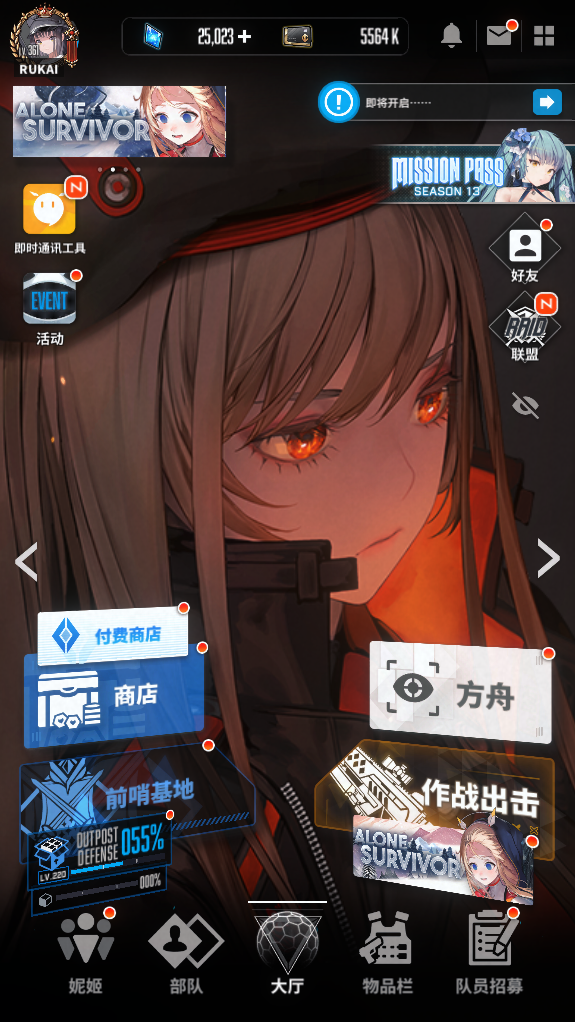

In [8]:
im

In [9]:
import paddlehub as hub
ocr = hub.Module(name="chinese_ocr_db_crnn_mobile", enable_mkldnn=True)

In [18]:
templates = [agent.image_map['home_shop_arena_currency_icon_1'], agent.image_map['home_shop_arena_currency_icon_2']]
locs = gio.locate_image(templates, region=agent.location_map['home'].to_bounding(), multi=True)

In [22]:
loc = locs[0][0]

In [54]:
def read(screen, ocr, debug=False):
        imgs = [screen,]
        results = ocr.recognize_text(
                        images=imgs,         # 图片数据，ndarray.shape 为 [H, W, C]，BGR格式；
                        use_gpu=False,            # 是否使用 GPU；若使用GPU，请先设置CUDA_VISIBLE_DEVICES环境变量
                        output_dir='ocr_result',  # 图片的保存路径，默认设为 ocr_result；
                        visualization=debug,       # 是否将识别结果保存为图片文件；
                        box_thresh=0.6,           # 检测文本框置信度的阈值；
                        text_thresh=0.8)          # 识别中文文本置信度的阈值；
        return results

In [55]:
im=gio.get_location_image(agent.location_map['home'])

In [56]:
results = read(gio.to_cv2(im), ocr, debug=True)

## update advise

In [7]:
import yaml
import json

In [4]:
with open("tables/zh/nikke/raw_text.txt", encoding='utf-8') as f:
    old_d = yaml.safe_load(f)

In [5]:
old_d

{'艾德米': [{'question': '您更喜欢哪一种呢？', 100: '猫咪。', 50: '狗狗。'},
  {'question': '我能为尤尔夏做点什么吗？', 100: '说声谢谢吧。', 50: '主动要求帮她的忙。'},
  {'question': '什么时候能懂事呢?', 100: '放下期待，心情就会好多了。', 50: '总有一天会懂事的。总有一天……'},
  {'question': '指挥官最喜欢前哨基地的哪个地方呢？', 100: '最喜欢艾德米工作的法院？', 50: '我最喜欢指挥官室了。'},
  {'question': '指挥官喜欢什么样的天气呢？', 100: '雨天。', 50: '晴天。'},
  {'question': '您曾为此感到遗憾或讨厌我们吗？', 100: '没有。', 50: '有。'},
  {'question': '您的理想型是什么样的呢？', 100: '可爱的人。', 50: '成熟的人。'},
  {'question': '指挥官您也认为，永恒的爱并不存在吗？', 100: '有永恒的爱。', 50: '没有永恒的爱。'},
  {'question': '指挥官您休息的时候，通常都喜欢去什么样的地方呢？', 100: '人少的公园。', 50: '人多的闹市区。'},
  {'question': '但是不知道该做什么。', 100: '要不要四处逛逛，找一些猫咪照片看看？', 50: '要不要试试看运动？'},
  {'question': '指挥官，您觉得呢？',
   100: '还没有看到结局，所以不想因为害怕结局就轻易放弃。',
   50: '可以继续尝试新的事物。'},
  {'question': '但是该送什么呢？', 100: '酒水', 50: '休假'},
  {'question': '指挥官，您平时喜欢听什么音乐呢？', 100: '平静柔和的音乐。', 50: '动感欢快的音乐。'},
  {'question': '指挥官，您经常做梦吗？', 100: '不怎么做梦。', 50: '我经常做梦。'},
  {'question': '如果成功收复地面了，您会有什么样的心情呢？', 100: '应该会很幸福吧。', 50: '不会有太大的感触。'},

In [21]:
new_d = {name:[line.get(100) for line in convo] for name, convo in old_d.items()}

In [22]:
new_d = {key: new_d[key] for key in sorted(new_d)}

In [23]:
new_d

{'D': ['你在做什么？',
  '我的决定会带给世界什么变化。',
  '两者都不是。',
  '我正朝这个方向努力。',
  '是生活的重量吗？',
  '把垃圾全部清掉。',
  '那个包包里装的是什么？',
  '我也不清楚。',
  '都喜欢。',
  '我会戴上惩罚你的王冠。',
  '不管怎样，都要今日事、今日毕。',
  '未按约定时间到来，是咨询师的失职！',
  '……要不要先去梳洗一下？',
  '我又没有犯罪，有什么好怕的？',
  '以任何方式来担起责任。',
  '假装若无其事，自己走自己的。',
  '雨天。',
  '睡觉。',
  '确认是否是危险物品。',
  '外表冰冷，内心火热，话多的人。'],
 'N102': ['淡味可乐饼。',
  '我摸摸你的头吧。',
  '……不是，是那个人认错了。',
  '没吃过，这是今天才出的新品呢。',
  '好，过一阵子我们就去。',
  '这样会感冒的。',
  '是不是因为你像明星一样漂亮呢？',
  '……不，不可怜。',
  '要一起去吗？',
  '安妮和我已经是同一部队的了。',
  '亲自演唱。',
  '说安妮想说的话吧。',
  '等咨询结束后，一起去吧。',
  '是有人和安妮同名呢。',
  '我也想一起去。',
  '非常有名，上过电视。',
  '真的很神奇。',
  '现在的这一刻，也是在累积回忆啊。',
  '其实我不吃辣可乐饼，因为太辣了。',
  '是不是穿着别人的衣服睡着了？'],
 '丽塔': ['想想你自己小时候的样子。',
  '还是要清理的。',
  '不是为了限制，而是为了安全。',
  '为了安全，必须严厉才行。',
  '桑迪不是孩子了。',
  '到时候，还会有适合你的工作的。',
  '也许是人生的经历太丰富了吧。',
  '其实阿妮斯的脚有疾病哦……',
  '是不是这个任务很无趣？',
  '伏特也有自己的烦恼。',
  '狠狠地教训教训他。',
  '年龄和兴趣有什么关系？',
  '那寂寞的小狗就从一只变成两只了。',
  '我支持每一个人。',
  '怪老头一个。',
  '我亲自帮你准备便当吧。',
  '在一群美女的簇拥中死去。',
  '袜子？',
  '……稀饭？',
  '加价转卖给她？'],
 '伊莎贝尔':

In [25]:
with open("tables/zh/nikke/attractive_counsel_dialog.json", encoding='utf-8') as f:
    old_d = json.load(f)

In [26]:
old_d

{'D': ['你在做什么？',
  '我的决定会带给世界什么变化。',
  '两者都不是。',
  '我正朝这个方向努力。',
  '是生活的重量吗？',
  '把垃圾全部清掉。',
  '那个包包里装的是什么？',
  '我也不清楚。',
  '都喜欢。',
  '我会戴上惩罚你的王冠。',
  '不管怎样，都要今日事、今日毕。',
  '未按约定时间到来，是咨询师的失职！',
  '……要不要先去梳洗一下？',
  '我又没有犯罪，有什么好怕的？',
  '以任何方式来担起责任。',
  '假装若无其事，自己走自己的。',
  '雨天。',
  '睡觉。',
  '确认是否是危险物品。',
  '外表冰冷，内心火热，话多的人。'],
 'N102': ['淡味可乐饼。',
  '我摸摸你的头吧。',
  '……不是，是那个人认错了。',
  '没吃过，这是今天才出的新品呢。',
  '好，过一阵子我们就去。',
  '这样会感冒的。',
  '是不是因为你像明星一样漂亮呢？',
  '……不，不可怜。',
  '要一起去吗？',
  '安妮和我已经是同一部队的了。',
  '亲自演唱。',
  '说安妮想说的话吧。',
  '等咨询结束后，一起去吧。',
  '是有人和安妮同名呢。',
  '我也想一起去。',
  '非常有名，上过电视。',
  '真的很神奇。',
  '现在的这一刻，也是在累积回忆啊。',
  '其实我不吃辣可乐饼，因为太辣了。',
  '是不是穿着别人的衣服睡着了？'],
 '丽塔': ['想想你自己小时候的样子。',
  '还是要清理的。',
  '不是为了限制，而是为了安全。',
  '为了安全，必须严厉才行。',
  '桑迪不是孩子了。',
  '到时候，还会有适合你的工作的。',
  '也许是人生的经历太丰富了吧。',
  '其实阿妮斯的脚有疾病哦……',
  '是不是这个任务很无趣？',
  '伏特也有自己的烦恼。',
  '狠狠地教训教训他。',
  '年龄和兴趣有什么关系？',
  '那寂寞的小狗就从一只变成两只了。',
  '我支持每一个人。',
  '怪老头一个。',
  '我亲自帮你准备便当吧。',
  '在一群美女的簇拥中死去。',
  '袜子？',
  '……稀饭？',
  '加价转卖给她？'],
 '伊莎贝尔':

In [ ]:
with open("tables/zh/nikke/attractive_counsel_dialog.json", 'w', encoding='utf-8') as f:
    json.dump(new_d, f, indent=4)

## random exp

In [11]:
im=gio.get_location_image(locs[1][0].resize(148, 226).translate(-38, -184))
im

NameError: name 'locs' is not defined

In [51]:
gio.read_text(im)

[[[[11, 5], [135, 5], [135, 25], [11, 25]], 'ANM1 代码手册'],
 [[[49, 123], [97, 123], [97, 143], [49, 143]], '剩余1'],
 [[[68, 184], [108, 184], [108, 208], [68, 208]], '420']]

In [55]:
gio.locate_image(agent.image_map['home_shop_arena_code_cost_1'], im)

LocationBox(left=72, top=186, width=34, height=22)

In [16]:
next_loc = gio.locate_image(agent.image_map['home_recruit_next_example'])
prev_loc = gio.locate_image(agent.image_map['home_recruit_previous_example'])

In [17]:
home_loc = agent.location_map['home']

In [18]:
next_loc - home_loc

LocationBox(left=527, top=508, width=-537, height=-973)

In [19]:
prev_loc - home_loc

LocationBox(left=8, top=506, width=-539, height=-969)

In [100]:
def action_with_change(action_func, args=(), kwargs={}, region=None):
    if not region:
        region = agent.location_map['home']

    current_im = gio.get_location_image(region)
    action_func(*args, **kwargs)
    gio.delay(1)
    same_im_loc = gio.exist_image(
        current_im, region=agent.location_map['home'].to_bounding(), confidence=0.99, timeout=2)
    if same_im_loc:
        return False
    return True

In [141]:
agent.focus()
change = agent.scroll(time=1)

In [133]:
change

True

In [166]:
agent.normal_shop_arena(['any_code_item', 'multi_code_item'])

 2023-04-08 23:36:02,700 - INFO - Normal arena shop session started...
 2023-04-08 23:36:43,154 - INFO - Succesfully purchased 0 items at once
 2023-04-08 23:36:47,382 - INFO - continue to search for new items
 2023-04-08 23:36:47,660 - INFO - Succesfully purchased 0 items at once
 2023-04-08 23:36:51,890 - INFO - continue to search for new items
 2023-04-08 23:37:04,236 - INFO - Succesfully purchased 0 items at once
 2023-04-08 23:37:08,462 - INFO - no more items to search for
 2023-04-08 23:37:08,463 - INFO - Succesfully purchased 0 items without refresh
 2023-04-08 23:37:08,463 - INFO - Tryin to refresh normal shop
 2023-04-08 23:37:17,252 - INFO - The refresh is not free
 2023-04-08 23:37:17,252 - INFO - Shopping session ended. Bought in total of 0 items.
 2023-04-08 23:37:17,253 - INFO - Exiting to home...
 2023-04-08 23:37:27,017 - INFO - Exited to home succesfully


In [22]:
agent.recruit()

 2023-04-09 00:55:56,757 - INFO - started recruit
 2023-04-09 00:56:16,218 - INFO - recruit ended
 2023-04-09 00:56:16,219 - INFO - Exiting to home...
 2023-04-09 00:56:29,567 - INFO - Exited to home succesfully


True

In [16]:
!pip uninstall -y numpy
!pip install "Numpy==1.23.5"

Found existing installation: numpy 1.24.2
Uninstalling numpy-1.24.2:
  Successfully uninstalled numpy-1.24.2


ERROR: Exception:
Traceback (most recent call last):
  File "D:\Development\nikke-assistant\venv\lib\site-packages\pip\_internal\cli\base_command.py", line 167, in exc_logging_wrapper
    status = run_func(*args)
  File "D:\Development\nikke-assistant\venv\lib\site-packages\pip\_internal\commands\uninstall.py", line 102, in run
    uninstall_pathset.commit()
  File "D:\Development\nikke-assistant\venv\lib\site-packages\pip\_internal\req\req_uninstall.py", line 420, in commit
    self._moved_paths.commit()
  File "D:\Development\nikke-assistant\venv\lib\site-packages\pip\_internal\req\req_uninstall.py", line 273, in commit
    save_dir.cleanup()
  File "D:\Development\nikke-assistant\venv\lib\site-packages\pip\_internal\utils\temp_dir.py", line 173, in cleanup
    rmtree(self._path)
  File "D:\Development\nikke-assistant\venv\lib\site-packages\pip\_vendor\tenacity\__init__.py", line 326, in wrapped_f
    return self(f, *args, **kw)
  File "D:\Development\nikke-assistant\venv\lib\site-pa

  Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl (14.6 MB)


You should consider upgrading via the 'D:\Development\nikke-assistant\venv\Scripts\python.exe -m pip install --upgrade pip' command.
